# This notebook is based on the exercise "California Housing Prices" in chapter 2 of the brilliant book "Hands-On Machine Learning with Scikit-Learn, Keras & TensorFlow" from A. Géron.

The dataset was downloaded from: <br>
https://github.com/ageron/handson-ml/tree/master/datasets/housing <br>
The webpage also contains information about the dataset.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)
print('Python version info: ' + str(sys.version_info))

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"
print('Scikit-Learn version: ' + sklearn.__version__ + '\n')

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import cross_val_score, StratifiedShuffleSplit, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures

pd.options.display.float_format = '{:.2f}'.format

print('Matplotlib version: ' + matplotlib.__version__)
print('Numpy version: ' + np.__version__)
print('Pandas version: ' + pd.__version__)
print()

Python version info: sys.version_info(major=3, minor=7, micro=5, releaselevel='final', serial=0)
Scikit-Learn version: 0.22.1

Matplotlib version: 3.1.1
Numpy version: 1.18.1
Pandas version: 1.0.3



**Global variables:**

In [2]:
random_st = 2
test_size1 = 0.2  # 20% Test data and 80% Training data
test_size2 = 0.5  # The Test data is split in 2 parts: 10% Validation data and 10 % Test data (0.5 x 0.2 = 0.1)

<br>

## Download the dataset

In [3]:
url = "https://raw.githubusercontent.com/ageron/handson-ml/master/datasets/housing/housing.csv"
df_housing_raw = pd.read_csv(url)

### Get a first impression of the dataset by using the methods ".head()", ".info()" and ".describe()"

In [4]:
df_housing_raw.head(3)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.00,880.00,129.00,322.00,126.00,8.33,452600.00,NEAR BAY
1,-122.22,37.86,21.00,7099.00,1106.00,2401.00,1138.00,8.30,358500.00,NEAR BAY
2,-122.24,37.85,52.00,1467.00,190.00,496.00,177.00,7.26,352100.00,NEAR BAY


The dataset contains 1 categorical column and 9 numerical columns.

In [5]:
df_housing_raw.info(memory_usage='deep')
df_housing_raw.memory_usage(deep=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 2.7 MB


Index                     128
longitude              165120
latitude               165120
housing_median_age     165120
total_rooms            165120
total_bedrooms         165120
population             165120
households             165120
median_income          165120
median_house_value     165120
ocean_proximity       1342940
dtype: int64

I convert the data type of the column "ocean_proximity" from 'object' to 'category' to save some memory. This is not really necessary, but it is possible to save memory if the datatypes of the columns are specified. Especially converting 'object' to 'category' saves memory.

In [6]:
df_housing_raw['ocean_proximity'] = df_housing_raw['ocean_proximity'].astype('category')

In [7]:
df_housing_raw.info(memory_usage='deep')
df_housing_raw.memory_usage(deep=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   longitude           20640 non-null  float64 
 1   latitude            20640 non-null  float64 
 2   housing_median_age  20640 non-null  float64 
 3   total_rooms         20640 non-null  float64 
 4   total_bedrooms      20433 non-null  float64 
 5   population          20640 non-null  float64 
 6   households          20640 non-null  float64 
 7   median_income       20640 non-null  float64 
 8   median_house_value  20640 non-null  float64 
 9   ocean_proximity     20640 non-null  category
dtypes: category(1), float64(9)
memory usage: 1.4 MB


Index                    128
longitude             165120
latitude              165120
housing_median_age    165120
total_rooms           165120
total_bedrooms        165120
population            165120
households            165120
median_income         165120
median_house_value    165120
ocean_proximity        21124
dtype: int64

2.7 MB before optimising vs. 1.4 MB after optimising, that's almost 50%!

The column (feature) "total_bedrooms" has 207 NaNs. This is approx. 1% of the number of datapoints, so I think it's safe to delete the rows, containing the NaNs. <br>

In [8]:
df_housing_raw = df_housing_raw.dropna()
df_housing_raw = df_housing_raw.reset_index(drop=True)

In [9]:
df_housing_raw.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20433.00,20433.00,20433.00,20433.00,20433.00,20433.00,20433.00,20433.00,20433.00
mean,-119.57,35.63,28.63,2636.50,537.87,1424.95,499.43,3.87,206864.41
std,2.00,2.14,12.59,2185.27,421.39,1133.21,382.30,1.90,115435.67
min,-124.35,32.54,1.00,2.00,1.00,3.00,1.00,0.50,14999.00
25%,-121.80,33.93,18.00,1450.00,296.00,787.00,280.00,2.56,119500.00
50%,-118.49,34.26,29.00,2127.00,435.00,1166.00,409.00,3.54,179700.00
75%,-118.01,37.72,37.00,3143.00,647.00,1722.00,604.00,4.74,264700.00
max,-114.31,41.95,52.00,39320.00,6445.00,35682.00,6082.00,15.00,500001.00


<br>

# Baseline Model

The easiest but probably not the most accurate way to predict the "median_house_value" is to take the mean (or the median) of the "median_house_values" contained in the training data. Let's see how the error metrics look. These values should be improved by using more sophisticated models later on.

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_housing_raw,
                                                    df_housing_raw['median_house_value'],
                                                    test_size=test_size1, random_state=random_st)

"df_housing_raw" is not entirely the correct parameter in this case, but it doesn't matter, because the feature columns won't be used (in this case).

In [11]:
mean_median_house_value = y_train.mean()
median_median_house_value = y_train.median()

In [12]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

mean_prediction = pd.Series([mean_median_house_value]).repeat(len(y_test))
median_prediction = pd.Series([median_median_house_value]).repeat(len(y_test))

r2_base_mean = r2_score(y_test, mean_prediction)
r2_base_median = r2_score(y_test, median_prediction)
rmse_base_mean = np.sqrt(mean_squared_error(y_test, mean_prediction))
rmse_base_median = np.sqrt(mean_squared_error(y_test, median_prediction))
mae_base_mean = mean_absolute_error(y_test, mean_prediction)
mae_base_median = mean_absolute_error(y_test, median_prediction)

df_error_metrics = pd.DataFrame({'R-Squared': [r2_base_mean, r2_base_median],
                                 'RMSE': [rmse_base_mean, rmse_base_median],
                                 'MAE': [mae_base_mean, mae_base_median],
                                 'CrossVal RMSE': [np.nan, np.nan],
                                 'CrossVal Stddev': [np.nan, np.nan]},
                                index=['Mean', 'Median'])
df_error_metrics

,R-Squared,RMSE,MAE,CrossVal RMSE,CrossVal Stddev
Mean,-0.00,113260.33,89755.36,nan,nan
Median,-0.05,116033.57,86736.69,nan,nan


<br>

# Data exploration

Convert the values of the columns "longitude" and "latitude" to geographical points:

In [13]:
import geopandas
from shapely.geometry import Point

gdf_housing_raw = geopandas.GeoDataFrame(df_housing_raw,
                                         geometry=geopandas.points_from_xy(df_housing_raw['longitude'],
                                                                           df_housing_raw['latitude']))
gdf_housing_raw.crs = {'init' :'epsg:4326'}

Load the California county borders (from: https://data.ca.gov/dataset/ca-geographic-boundaries)

In [14]:
cal_counties = geopandas.read_file("CA_Counties/CA_Counties_TIGER2016.shp")
cal_counties.head(3)

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,06,091,00277310,06091,Sierra,Sierra County,06,H1,G4020,None,None,None,A,2468694587,23299110,+39.5769252,-120.5219926,"POLYGON ((-13431319.751 4821511.426, -13431312..."
1,06,067,00277298,06067,Sacramento,Sacramento County,06,H1,G4020,472,40900,None,A,2499183617,76073827,+38.4500114,-121.3404409,"POLYGON ((-13490651.476 4680831.603, -13490511..."
2,06,083,00277306,06083,Santa Barbara,Santa Barbara County,06,H1,G4020,None,42200,None,A,7084000598,2729814515,+34.5370572,-120.0399729,"MULTIPOLYGON (((-13423116.772 4042044.149, -13..."


The columns "NAMELSAD" and "geometry" are important, so I only keep those.

In [15]:
cal_counties = cal_counties[['NAMELSAD', 'geometry']]

The coordinate reference system (crs) of the Points (gdf_housing_raw) doesn't match the crs of the Polygons (cal_counties), so I have to adapt the crs.

In [16]:
cal_counties = cal_counties.to_crs({'init': 'epsg:4326'})

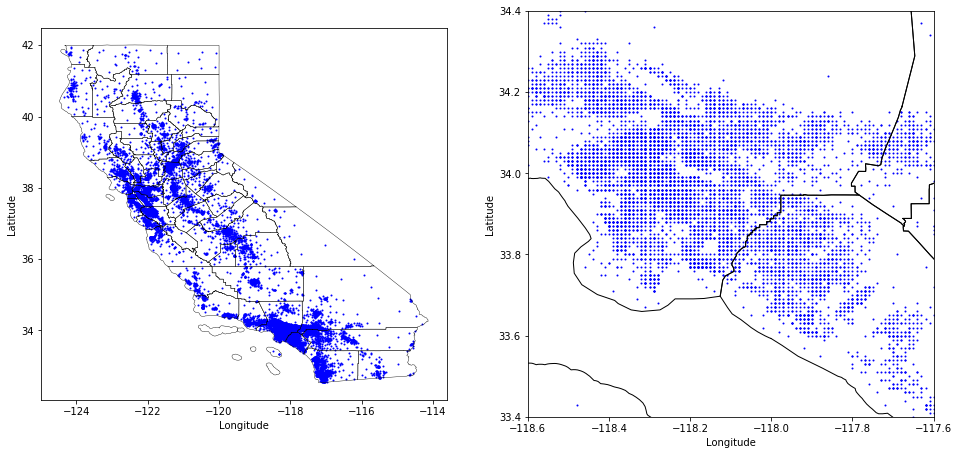

In [17]:
# Plot the datapoints together with the California county borders

import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
gdf_housing_raw.plot(markersize=1, color='blue', ax=ax1)
cal_counties.plot(facecolor="none", edgecolor='k', lw=0.4, ax=ax1)
gdf_housing_raw.plot(markersize=1, color='blue', ax=ax2)
cal_counties.plot(facecolor="none", edgecolor='k', ax=ax2)
ax2.set_xlim(-118.6, -117.6)  # Zoom to Los Angeles
ax2.set_ylim(33.4, 34.4)
ax1.set_xlabel('Longitude'), ax2.set_xlabel(ax1.get_xlabel())
ax1.set_ylabel('Latitude'), ax2.set_ylabel(ax1.get_ylabel());

As was mentioned above, the values of the columns "latitude" and "longitude" are not of meaningful scale, so I decided to find out which county they belong to and use that as a feature for training later on.

In [18]:
gdf_housing_joined = geopandas.sjoin(gdf_housing_raw, cal_counties, how="left", op='intersects')
gdf_housing_joined = gdf_housing_joined.drop(columns=['index_right'])
df_housing_joined = pd.DataFrame(gdf_housing_joined.drop(columns=['geometry']))

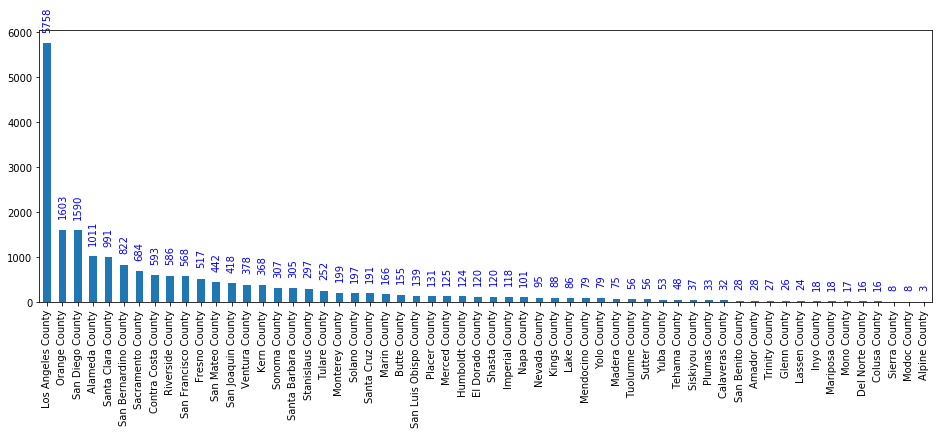

In [19]:
ax = df_housing_joined['NAMELSAD'].value_counts().plot(kind='bar', figsize=(16, 5))
for i, v in enumerate(df_housing_joined['NAMELSAD'].value_counts()):
    ax.text(i, v + 300, str(v), color='blue', rotation=90, ha='center', fontsize=10);

By far the most datapoints are located in Los Angeles County. This is not optimal for using the location (the County) as a feature. A more evenly distribution would have been better. <br>
**I combine all Counties with less than 20 data points in the County "Other County".**

In [20]:
to_be_combined = df_housing_joined['NAMELSAD'].value_counts() < 20
to_be_combined = to_be_combined[to_be_combined == True].index
df_housing_joined.loc[df_housing_joined['NAMELSAD'].isin(to_be_combined), 'NAMELSAD'] = 'Other County'

In [21]:
corr_matrix = df_housing_raw.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.00
median_income         0.69
total_rooms           0.13
housing_median_age    0.11
households            0.06
total_bedrooms        0.05
population           -0.03
longitude            -0.05
latitude             -0.14
Name: median_house_value, dtype: float64

Except the "median_income" there is at best a very weak correlation between the features and the target.

<br>

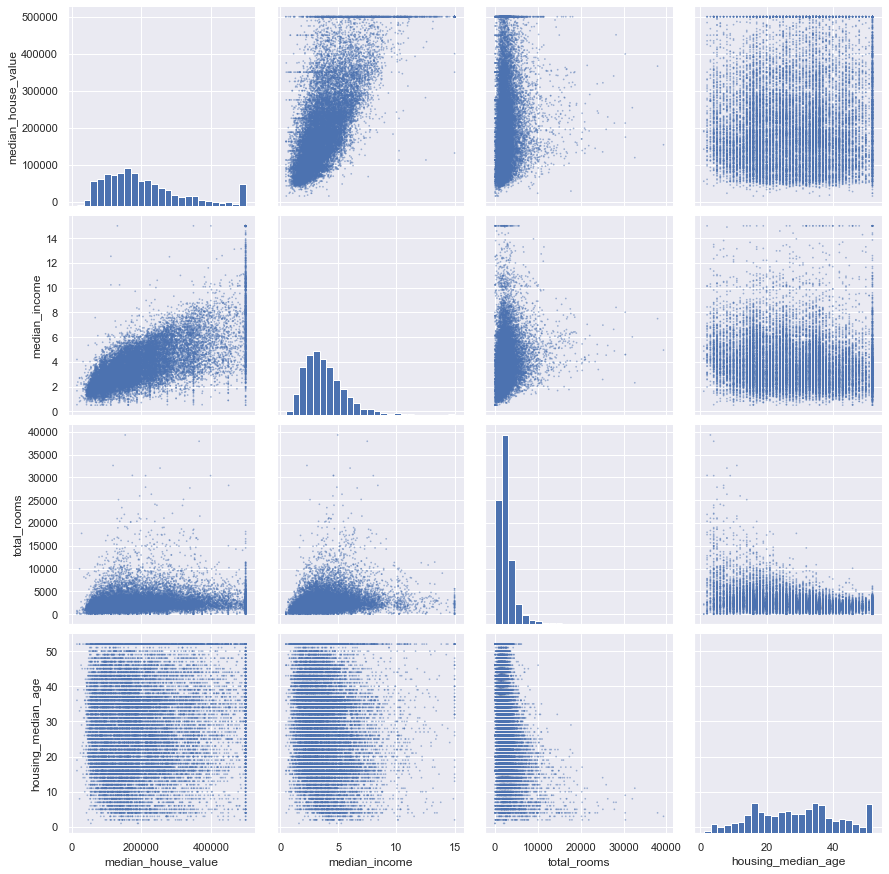

In [22]:
sns.set()
cols = ['median_house_value', 'median_income', 'total_rooms', 'housing_median_age']
g = sns.pairplot(df_housing_raw[cols], height=3, kind='scatter', diag_kind = "hist", 
                 plot_kws={'alpha': 0.5, 's': 3, 'edgecolor': 'None'}, 
                 diag_kws={'bins': 25})

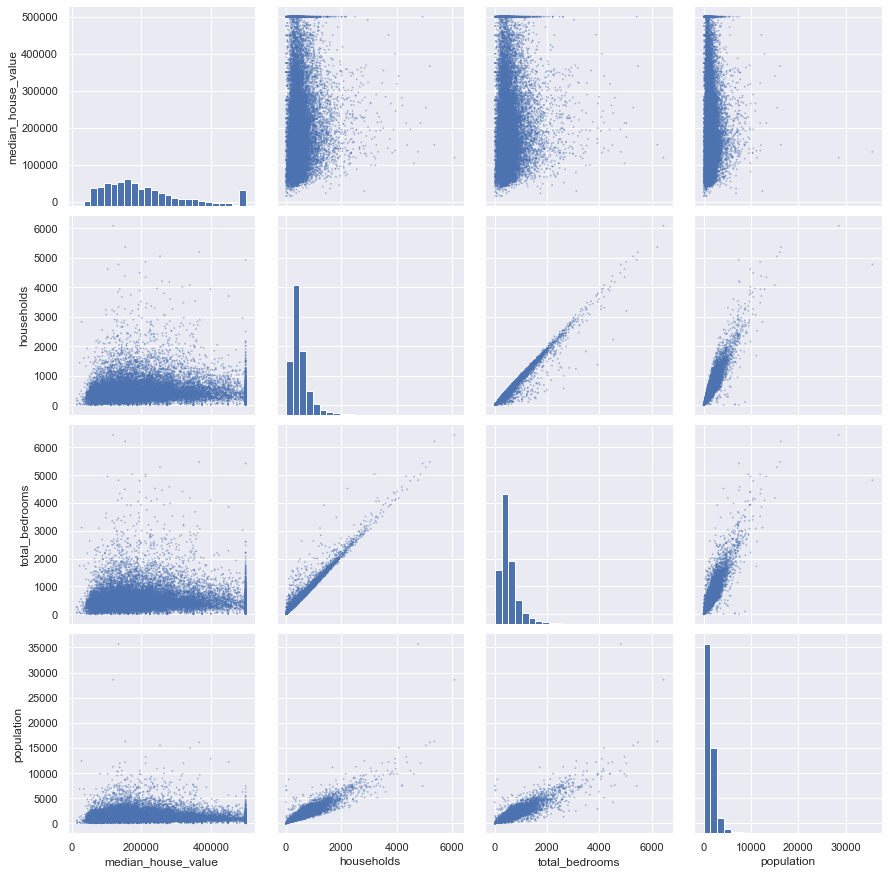

In [23]:
sns.set()
cols = ['median_house_value', 'households', 'total_bedrooms', 'population']
g = sns.pairplot(df_housing_raw[cols], height=3, kind='scatter', diag_kind = "hist", 
                 plot_kws={'alpha': 0.5, 's': 3, 'edgecolor': 'None'}, 
                 diag_kws={'bins': 25})

What can be seen in the scatter plots/histograms? <br>
The scatter plots show that there is something wrong with the very high values of "median_house_value" and "housing_median_age". They occur far too often. To a lesser degree this also applies for "median_income". Furthermore, a linear relationship concerning the target ("median_house_value") is only visible when plotted against "median_income". There are several strong linear relationships between several other features, e.g. "households" vs. "population". Moreover, the scatter plots show some outliers. <br>
The histograms show mostly unimodal distributions. Some distributions can roughly considered to be normal distributed, though several outliers squeeze the bins, which makes the histograms difficult to interpret.

The next code cell is there to also have a look at the distribution of the categorical feature "ocean_proximity":

In [24]:
df_housing_raw['ocean_proximity'].value_counts()

<1H OCEAN     9034
INLAND        6496
NEAR OCEAN    2628
NEAR BAY      2270
ISLAND           5
Name: ocean_proximity, dtype: int64

<br>

# First simple Linear Regression model

In [25]:
df_housing_joined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20433 entries, 0 to 20432
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   longitude           20433 non-null  float64 
 1   latitude            20433 non-null  float64 
 2   housing_median_age  20433 non-null  float64 
 3   total_rooms         20433 non-null  float64 
 4   total_bedrooms      20433 non-null  float64 
 5   population          20433 non-null  float64 
 6   households          20433 non-null  float64 
 7   median_income       20433 non-null  float64 
 8   median_house_value  20433 non-null  float64 
 9   ocean_proximity     20433 non-null  category
 10  NAMELSAD            20430 non-null  object  
dtypes: category(1), float64(9), object(1)
memory usage: 1.7+ MB


Split the data:

In [26]:
def split_data(labels, features):
    X_train, X_test, y_train, y_test = train_test_split(labels,
                                                        features,
                                                        test_size=test_size1,
                                                        random_state=random_st)
    X_val, X_test, y_val, y_test = train_test_split(X_test,
                                                    y_test,
                                                    test_size=test_size2,
                                                    random_state=random_st) # 0.2 x 0.5 = 0.1
    return X_train, y_train, X_val, y_val, X_test, y_test

In [27]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(df_housing_joined['median_income'],
                                                            df_housing_joined['median_house_value'])

Initialize, Fit and Predict:

In [28]:
lin_reg_simple_1feature = LinearRegression()
lin_reg_simple_1feature.fit(pd.DataFrame(X_train), y_train)
lin_reg_simple_1feature_predictions_train = lin_reg_simple_1feature.predict(pd.DataFrame(X_train))
lin_reg_simple_1feature_predictions_val = lin_reg_simple_1feature.predict(pd.DataFrame(X_val))

Evaluation of the model performance:

In [29]:
def calc_error_metrics(model, X_train, y_train, y_val, predictions_train, predictions_val):
    print(f'R-Squared Training Set:   {r2_score(y_train, predictions_train):.3f}' +
          f'\nR-Squared Validation Set: {r2_score(y_val, predictions_val):.3f}')
    print(f'RMSE Training Set:   {np.sqrt(mean_squared_error(y_train, predictions_train)):.1f}' +
          f'\nRMSE Validation Set: {np.sqrt(mean_squared_error(y_val, predictions_val)):.1f}')
    print(f'MAE Training Set:   {mean_absolute_error(y_train, predictions_train):.1f}' +
          f'\nMAE Validation Set: {mean_absolute_error(y_val, predictions_val):.1f}\n')
    
    score = np.sqrt(-1 * cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv=4, n_jobs=-1))
    print('k-fold CROSS Validation:')
    print('Scores: ', score)
    print('Mean Score: ', score.mean())
    print('Standard dev.: ', score.std())
    print()
    return [r2_score(y_val, predictions_val),
            np.sqrt(mean_squared_error(y_val, predictions_val)),
            mean_absolute_error(y_val, predictions_val),
            score.mean(),
            score.std()]

In [30]:
lin_reg_simple_1feature_metrics = calc_error_metrics(lin_reg_simple_1feature, pd.DataFrame(X_train),
                                                   y_train, y_val, 
                                                   lin_reg_simple_1feature_predictions_train,
                                                   lin_reg_simple_1feature_predictions_val)

R-Squared Training Set:   0.479
R-Squared Validation Set: 0.457
RMSE Training Set:   83734.0
RMSE Validation Set: 82749.3
MAE Training Set:   62672.9
MAE Validation Set: 62083.1

k-fold CROSS Validation:
Scores:  [82941.64850374 84649.68956253 84063.86603004 83284.3749147 ]
Mean Score:  83734.89475274974
Standard dev.:  666.573210782218



In [31]:
def scatter_true_vs_predicted(train_labels, train_predictions, val_labels, val_predictions):
    plt.rcParams.update({'axes.labelsize': 16})
    f, ax1 = plt.subplots(figsize=(8, 8))
    ax1.scatter(train_labels, train_predictions, s=2, alpha=0.3, label='Training Set')
    ax1.scatter(val_labels, val_predictions, s=2, alpha=0.3, label='Validation Set', color='red')
    ax1.plot([0, 500000], [0, 500000], color='black')
    ax1.axis('equal')
    ax1.set_title('True vs. Predicted')
    ax1.set_xlabel('True \"median_house_value\"')
    ax1.set_ylabel('Predicted \"median_house_value\"')
    ax1.text(0.03, 0.87, f'Number of data points:', transform=ax1.transAxes)
    ax1.text(0.03, 0.84, f'Training: {len(train_labels)}', transform=ax1.transAxes)
    ax1.text(0.03, 0.81, f'Validation: {len(val_labels)}', transform=ax1.transAxes)
    ax1.legend();

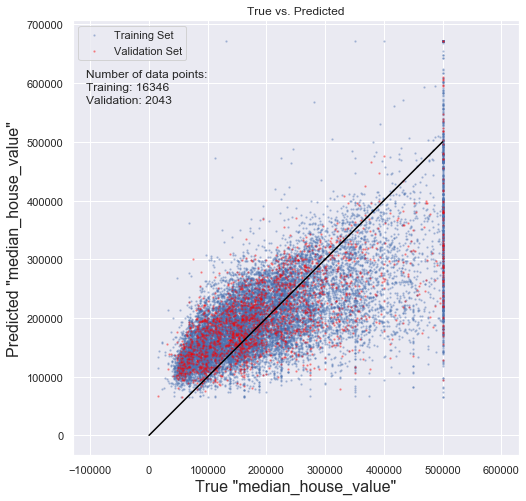

In [32]:
scatter_true_vs_predicted(y_train, lin_reg_simple_1feature_predictions_train,
                          y_val, lin_reg_simple_1feature_predictions_val)

In [33]:
import seaborn as sns

def plot_distribution(train_labels, train_predictions, val_labels, val_predictions):
    f, ax = plt.subplots(1, 2, figsize=(16, 8), sharex=True, sharey=True)
    sns.distplot(train_labels.values, hist=False, color="b", label='True', ax=ax[0])
    sns.distplot(train_predictions, hist=False, color="r", label='Predictions', ax=ax[0])
    sns.distplot(val_labels.values, hist=False, color="b", label='True', ax=ax[1])
    sns.distplot(val_predictions, hist=False, color="r", label='Predictions', ax=ax[1])
    ax[0].set_title('Relative distribution plot of Predicted and True Training Data')
    ax[1].set_title('Relative distribution plot of Predicted and True Validation Data')
    ax[0].set_xlabel('median_house_price'); ax[1].set_xlabel(ax[0].get_xlabel())
    ax[0].set_ylabel('Relative frequency');

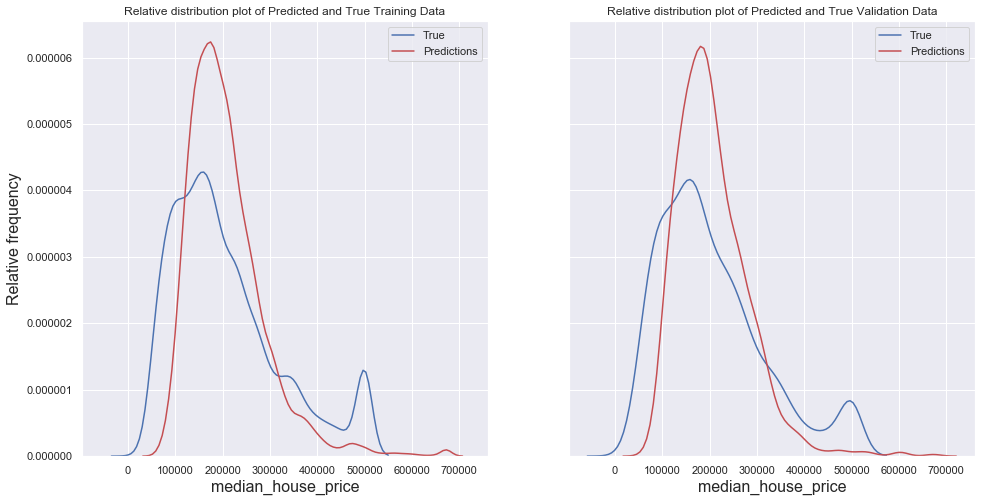

In [34]:
plot_distribution(y_train, lin_reg_simple_1feature_predictions_train,
                  y_val, lin_reg_simple_1feature_predictions_val)

In [35]:
df_error_metrics.loc['LinReg Model 1 feature'] = lin_reg_simple_1feature_metrics
df_error_metrics

,R-Squared,RMSE,MAE,CrossVal RMSE,CrossVal Stddev
Mean,-0.00,113260.33,89755.36,nan,nan
Median,-0.05,116033.57,86736.69,nan,nan
LinReg Model 1 feature,0.46,82749.30,62083.10,83734.89,666.57


The first simple linear regression model delivered an expected improvement compared to the baseline model.

### What if I had taken all numerical features?

In [36]:
features_numerical = ['longitude', 'latitude', 'housing_median_age', 'total_rooms',
                      'total_bedrooms', 'population', 'households', 'median_income']

X_train, y_train, X_val, y_val, X_test, y_test = split_data(df_housing_joined[features_numerical],
                                                            df_housing_joined['median_house_value'])

In [37]:
lin_reg_simple_allfeatures = LinearRegression()
lin_reg_simple_allfeatures.fit(pd.DataFrame(X_train), y_train)
lin_reg_simple_allfeatures_predictions_train = lin_reg_simple_allfeatures.predict(X_train)
lin_reg_simple_allfeatures_predictions_val = lin_reg_simple_allfeatures.predict(X_val)

In [38]:
lin_reg_simple_allfeatures_metrics = calc_error_metrics(lin_reg_simple_allfeatures, X_train,
                                                        y_train, y_val, 
                                                        lin_reg_simple_allfeatures_predictions_train,
                                                        lin_reg_simple_allfeatures_predictions_val)

R-Squared Training Set:   0.639
R-Squared Validation Set: 0.636
RMSE Training Set:   69651.3
RMSE Validation Set: 67762.7
MAE Training Set:   50830.6
MAE Validation Set: 49568.0

k-fold CROSS Validation:
Scores:  [70012.28435955 70033.28954134 69669.76534428 69399.10673782]
Mean Score:  69778.61149574637
Standard dev.:  262.3619923722863



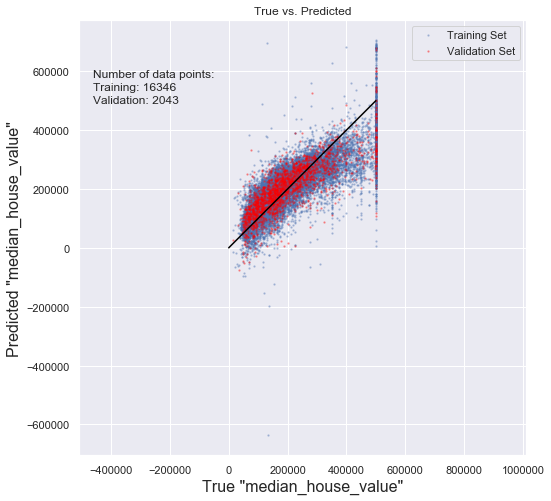

In [39]:
scatter_true_vs_predicted(y_train, lin_reg_simple_allfeatures_predictions_train,
                          y_val, lin_reg_simple_allfeatures_predictions_val)

There are a couple of "median_house_values" that are predicted negative. One value sticks out:

In [40]:
np.where(lin_reg_simple_allfeatures_predictions_train < -500000)

(array([389]),)

In [41]:
lin_reg_simple_allfeatures_predictions_train[389]

-637041.592861799

In [42]:
y_train.iloc[389]

134400.0

In [43]:
X_train.iloc[389, :]

longitude             -117.42
latitude                33.35
housing_median_age      14.00
total_rooms          25135.00
total_bedrooms        4819.00
population           35682.00
households            4769.00
median_income            2.57
Name: 15212, dtype: float64

The "median_income" is 2.57 which is an average median income (see histogramm further up). <br>
The "households" is 4769 which is extreme!!! <br>
The "population" is 35682 and this is extreme as well! <br>
The "total_bedrooms" is 4819 and is extreme! <br>
The "total_rooms" 25135 and is extreme! <br>
So all these extreme numbers might be an explanation why the result of the prediction is far off.

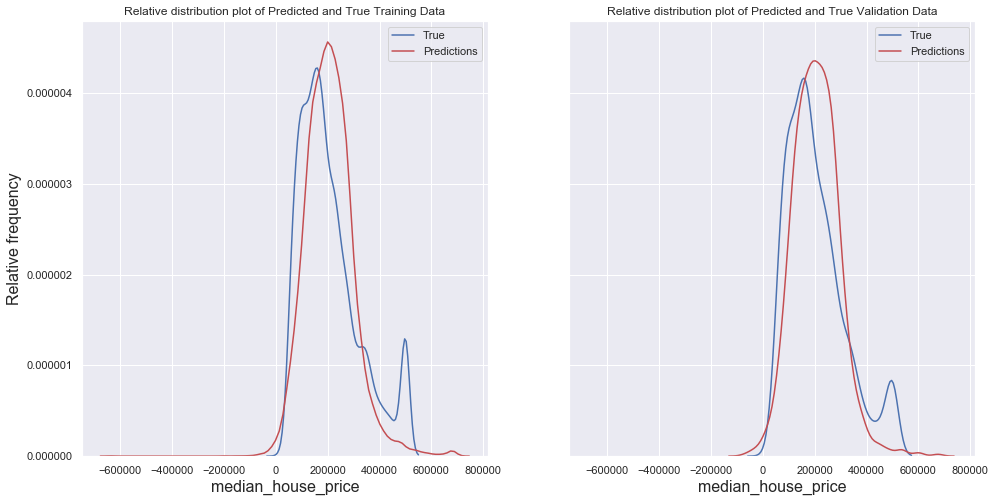

In [44]:
plot_distribution(y_train, lin_reg_simple_allfeatures_predictions_train,
                  y_val, lin_reg_simple_allfeatures_predictions_val)

In [45]:
df_error_metrics.loc['LinReg Model all features'] = lin_reg_simple_allfeatures_metrics
df_error_metrics

,R-Squared,RMSE,MAE,CrossVal RMSE,CrossVal Stddev
Mean,-0.00,113260.33,89755.36,nan,nan
Median,-0.05,116033.57,86736.69,nan,nan
LinReg Model 1 feature,0.46,82749.30,62083.10,83734.89,666.57
LinReg Model all features,0.64,67762.72,49568.02,69778.61,262.36


Even though the other features did only show a very weak correlation, taking them also into account improves the error metrics. This time with a better performance of the Test-Set (RMSE and MAE of Train-Set are higher)! The reason I guess is the big outlier in the Training-Set.

### Like mentioned above Longitude and Latitude don't have a meaningful scale, so what happens if I leave them out?

In [46]:
features_numerical = ['housing_median_age', 'total_rooms',
                      'total_bedrooms', 'population', 'households', 'median_income']

X_train, y_train, X_val, y_val, X_test, y_test = split_data(df_housing_joined[features_numerical],
                                                            df_housing_joined['median_house_value'])

In [47]:
lin_reg_simple_nolatlon = LinearRegression()
lin_reg_simple_nolatlon.fit(X_train, y_train)
lin_reg_simple_nolatlon_predictions_train = lin_reg_simple_nolatlon.predict(X_train)
lin_reg_simple_nolatlon_predictions_val = lin_reg_simple_nolatlon.predict(X_val)

In [48]:
lin_reg_simple_nolatlon_metrics = calc_error_metrics(lin_reg_simple_nolatlon, X_train,
                                                     y_train, y_val,
                                                     lin_reg_simple_nolatlon_predictions_train,
                                                     lin_reg_simple_nolatlon_predictions_val)

R-Squared Training Set:   0.571
R-Squared Validation Set: 0.563
RMSE Training Set:   75954.0
RMSE Validation Set: 74292.3
MAE Training Set:   55864.8
MAE Validation Set: 54838.4

k-fold CROSS Validation:
Scores:  [75585.75469505 75916.82022217 76793.66063558 75850.31683084]
Mean Score:  76036.638095909
Standard dev.:  454.27164324557504



In [49]:
df_error_metrics.loc['LinReg Model no Lat/Lon'] = lin_reg_simple_nolatlon_metrics
df_error_metrics

,R-Squared,RMSE,MAE,CrossVal RMSE,CrossVal Stddev
Mean,-0.00,113260.33,89755.36,nan,nan
Median,-0.05,116033.57,86736.69,nan,nan
LinReg Model 1 feature,0.46,82749.30,62083.10,83734.89,666.57
LinReg Model all features,0.64,67762.72,49568.02,69778.61,262.36
LinReg Model no Lat/Lon,0.56,74292.30,54838.45,76036.64,454.27


Leaving out the features "longitude" and "latitude" leads to poorer error metrics.

<br>

# Removing outliers

The previous models where trained with the original data, which included outliers. By removing the outliers in the next step, I hope to improve the model performance.

In [50]:
df_housing_cleaned = df_housing_joined.copy(deep=True)

### <ul><li> Outliers in "median_house_value" </li></ul>

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


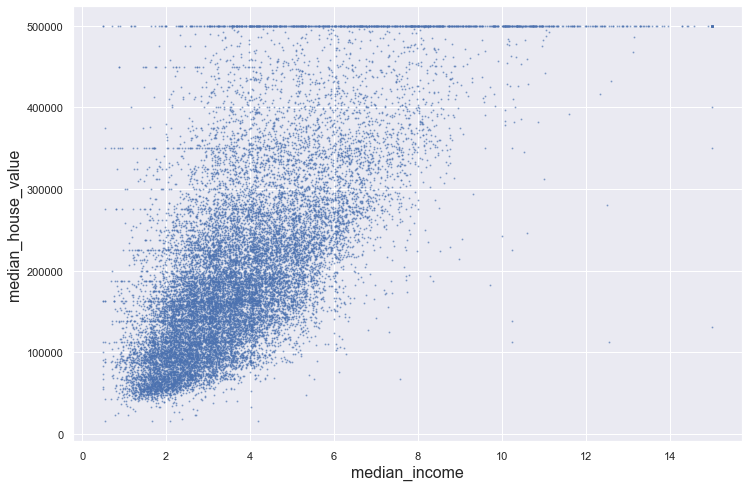

In [51]:
df_housing_cleaned.plot(kind='scatter', x='median_income', y='median_house_value', alpha=0.5, s=1.0, figsize=(12, 8));

Clearly some **inconsistencies** at "median_house_value" approx. 500.000. Also at 450.000, 350.000, maybe 280.000, ...
This needs some further investigation:

**First: Find how many times specific "median_house_values" occur**

In [52]:
medianhousevalue_occur = df_housing_cleaned['median_house_value'].value_counts().sort_values()
df_housevalue_occur = pd.DataFrame({'occurances': medianhousevalue_occur})

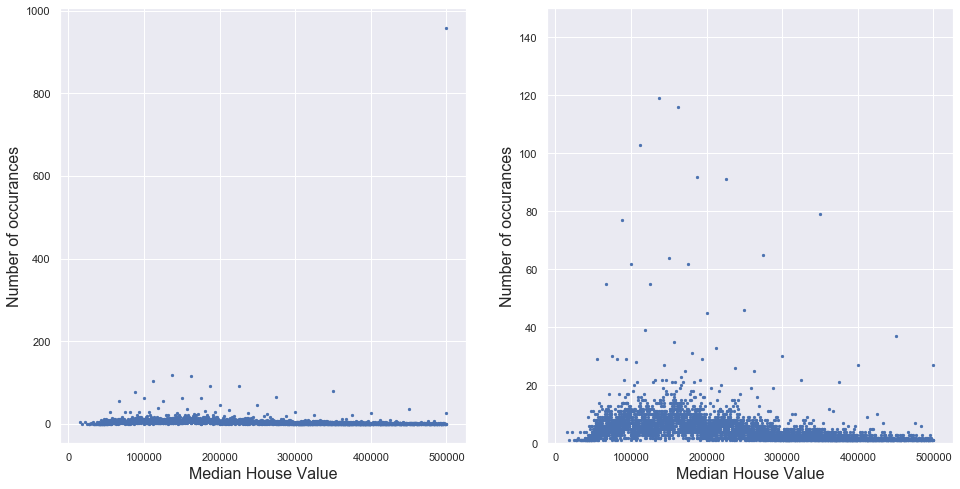

In [53]:
f, (ax1, ax2) = plt.subplots(1, 2, sharex=True)
plt.gcf().set_size_inches(16, 8)
ax1.scatter(df_housevalue_occur.index, df_housevalue_occur['occurances'], s=5);
ax1.grid(True)
ax2.scatter(df_housevalue_occur.index, df_housevalue_occur['occurances'], s=5);
ax2.set_ylim(0, 150)
ax2.grid(True)
ax1.set_xlabel('Median House Value')
ax1.set_ylabel('Number of occurances')
ax2.set_xlabel('Median House Value')
ax2.set_ylabel('Number of occurances');

There seems to be certain "Median House Values" that occur significantly more often than others (=> **Outliers**)

**Second: Remove the Outliers (Outliers in this case: occurance > 25):**

In [54]:
outliers = df_housing_cleaned['median_house_value'].value_counts() > 25
outliers = outliers.index[outliers == True]
df_housing_cleaned['bad'] = df_housing_cleaned['median_house_value'].isin(outliers)

In [55]:
df_housing_cleaned['bad'].value_counts()

False    17858
True      2575
Name: bad, dtype: int64

In [56]:
df_housing_bad = df_housing_cleaned[df_housing_cleaned['bad'] == True]
df_housing_cleaned = df_housing_cleaned.drop(df_housing_cleaned[df_housing_cleaned['bad'] == True].index)
df_housing_cleaned = df_housing_cleaned.reset_index(drop=True)

2575 rows are identified as outliers. (Their "median house value" occurs more often than 25 times.) These rows will be deleted.

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


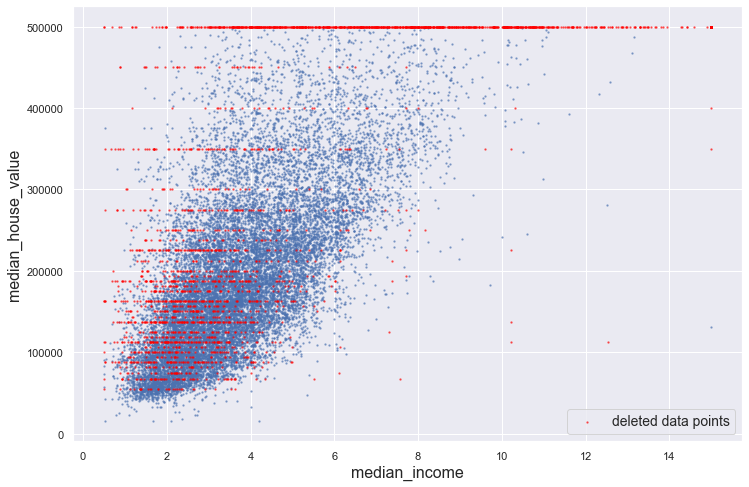

In [57]:
df_housing_cleaned.plot(kind='scatter', x='median_income', y='median_house_value', alpha=0.5, s=2.0, figsize=(12, 8))
df_housing_bad.plot(kind='scatter', x='median_income', y='median_house_value', alpha=0.5, s=2.0, color='red', ax=plt.gca(), label='deleted data points')
plt.gca().legend(fontsize=14);

In [58]:
del df_housing_bad
df_housing_cleaned = df_housing_cleaned.drop('bad', axis=1)
df_housing_cleaned.shape

(17858, 11)

### <ul><li> Outliers in "housing_median_age" </li></ul>
In this case a look at the "housing_median_age" histogramm would have been enough. In the diagramm the extreme values at 52 look very suspicious. The distribution towards the end of the X-axis has a decreasing occurance and suddenly it shoots up again. It might be possible that a big firm (or government) decided to build that many houses 52 years ago, but I will delete the datapoints anyway.

In [59]:
housingmedianage_occur = df_housing_cleaned['housing_median_age'].value_counts().sort_values(ascending=False)
df_houseage_occur = pd.DataFrame({'occurances': housingmedianage_occur})
df_houseage_occur.head(7)

,occurances
52.00,916
36.00,772
35.00,742
16.00,669
17.00,619
34.00,595
33.00,537


In [60]:
df_housing_cleaned = df_housing_cleaned.drop(df_housing_cleaned[df_housing_cleaned['housing_median_age'] == 52.0].index)
df_housing_cleaned = df_housing_cleaned.reset_index(drop=True)
df_housing_cleaned.shape

(16942, 11)

### <ul><li> Outliers in "median_income" </li></ul>
This time it's the look in the scatter plots, which reveals an unnatural high number of occurances at the maximum value of "median_income". So all values equal to 15.0 will be deleted.

In [61]:
df_housing_cleaned = df_housing_cleaned.drop(df_housing_cleaned[df_housing_cleaned['median_income'] >= 15.0].index)
df_housing_cleaned = df_housing_cleaned.reset_index(drop=True)
df_housing_cleaned.shape

(16942, 11)

It looks like the already were dropped, so they must have been connected to either "median_house_value" or "housing_median_age".

### <ul><li> Outliers in "population" </li></ul>
There seems to be one outlier with value bigger than 35000 which I delete:

In [62]:
df_housing_cleaned = df_housing_cleaned.drop(df_housing_cleaned[df_housing_cleaned['population'] >= 35000].index)
df_housing_cleaned = df_housing_cleaned.reset_index(drop=True)
df_housing_cleaned.shape

(16941, 11)

Again I visually check the scatter plots / histograms for outliers:

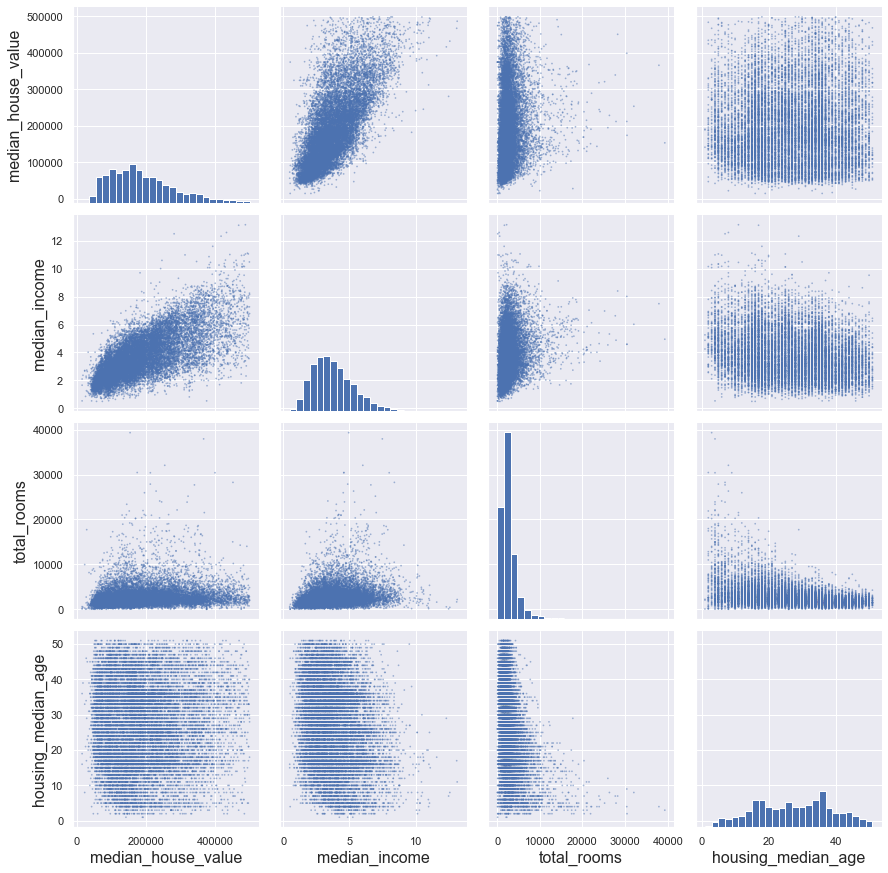

In [63]:
cols = ['median_house_value', 'median_income', 'total_rooms', 'housing_median_age']
g = sns.pairplot(df_housing_cleaned[cols], height=3, kind='scatter', diag_kind = "hist", 
                 plot_kws={'alpha': 0.5, 's': 3, 'edgecolor': 'None'}, 
                 diag_kws={'bins': 25})

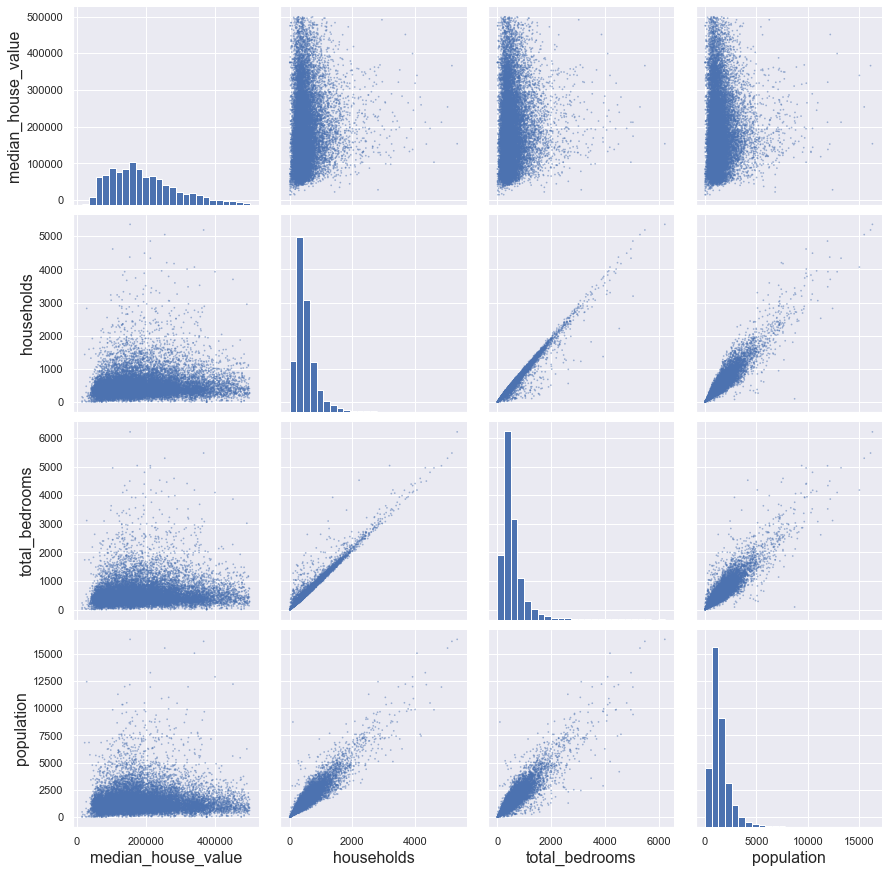

In [64]:
cols = ['median_house_value', 'households', 'total_bedrooms', 'population']
g = sns.pairplot(df_housing_cleaned[cols], height=3, kind='scatter', diag_kind = "hist", 
                 plot_kws={'alpha': 0.5, 's': 3, 'edgecolor': 'None'}, 
                 diag_kws={'bins': 25})

<br>

# Model performance after removing outliers

In [65]:
features_numerical = ['longitude', 'latitude', 'housing_median_age', 'total_rooms',
                      'total_bedrooms', 'population', 'households', 'median_income']

X_train, y_train, X_val, y_val, X_test, y_test = split_data(df_housing_joined[features_numerical],
                                                            df_housing_joined['median_house_value'])

In [66]:
lin_reg_simple_no_outliers = LinearRegression()
lin_reg_simple_no_outliers.fit(pd.DataFrame(X_train), y_train)
lin_reg_simple_no_outliers_predictions_train = lin_reg_simple_no_outliers.predict(X_train)
lin_reg_simple_no_outliers_predictions_val = lin_reg_simple_no_outliers.predict(X_val)

In [67]:
lin_reg_simple_no_outliers_metrics = calc_error_metrics(lin_reg_simple_no_outliers, X_train,
                                                        y_train, y_val,
                                                        lin_reg_simple_no_outliers_predictions_train,
                                                        lin_reg_simple_no_outliers_predictions_val)

R-Squared Training Set:   0.639
R-Squared Validation Set: 0.636
RMSE Training Set:   69651.3
RMSE Validation Set: 67762.7
MAE Training Set:   50830.6
MAE Validation Set: 49568.0

k-fold CROSS Validation:
Scores:  [70012.28435955 70033.28954134 69669.76534428 69399.10673782]
Mean Score:  69778.61149574637
Standard dev.:  262.3619923722863



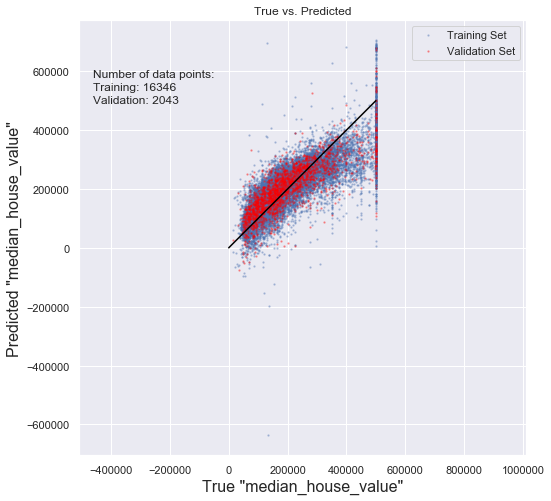

In [68]:
scatter_true_vs_predicted(y_train, lin_reg_simple_no_outliers_predictions_train,
                          y_val, lin_reg_simple_no_outliers_predictions_val)

In [69]:
df_error_metrics.loc['LinReg Model no outliers'] = lin_reg_simple_no_outliers_metrics
df_error_metrics

,R-Squared,RMSE,MAE,CrossVal RMSE,CrossVal Stddev
Mean,-0.00,113260.33,89755.36,nan,nan
Median,-0.05,116033.57,86736.69,nan,nan
LinReg Model 1 feature,0.46,82749.30,62083.10,83734.89,666.57
LinReg Model all features,0.64,67762.72,49568.02,69778.61,262.36
LinReg Model no Lat/Lon,0.56,74292.30,54838.45,76036.64,454.27
LinReg Model no outliers,0.64,67762.72,49568.02,69778.61,262.36


The removal of the outliers lead to a big improvement of the error metrics.

<br>

# Feature Engineering

### 1.) Create new features by combining existing features

Each row contains data not about a single house, but about many houses (From the data description (see link further up): The data contains one row per census block group. A block group is the smallest geographical unit for which the U.S. Census Bureau publishes sample data (a block group typically has a population of 600 to 3,000 people).) <br>
That's why there are values like for example "total_bedrooms=129". I think, it is a good idea (not my idea, but I saw that on a GCP course) to relate some features to the number of households.

In [70]:
df_housing_extended = df_housing_cleaned.copy(deep=True)
df_housing_extended['rooms_per_household'] = df_housing_extended['total_rooms'] / df_housing_extended['households']
df_housing_extended['bedrooms_per_household'] = df_housing_extended['total_bedrooms'] / df_housing_extended['households']
df_housing_extended['bedrooms_per_room'] = df_housing_extended['total_bedrooms'] / df_housing_extended['total_rooms']

In [71]:
corr_matrix = df_housing_extended.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value        1.00
median_income             0.69
total_rooms               0.15
rooms_per_household       0.15
households                0.10
total_bedrooms            0.08
population                0.02
housing_median_age        0.01
longitude                -0.02
bedrooms_per_household   -0.07
latitude                 -0.17
bedrooms_per_room        -0.28
Name: median_house_value, dtype: float64

In [72]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(df_housing_extended[df_housing_extended.columns.difference(['median_house_value', 'ocean_proximity', 'NAMELSAD'])],
                                                            df_housing_extended['median_house_value'])

In [73]:
lin_reg_simple_extfeatures1 = LinearRegression()
lin_reg_simple_extfeatures1.fit(X_train, y_train)
lin_reg_simple_extfeatures1_predictions_train = lin_reg_simple_extfeatures1.predict(X_train)
lin_reg_simple_extfeatures1_predictions_val = lin_reg_simple_extfeatures1.predict(X_val)

In [74]:
lin_reg_simple_extfeatures1_metrics = calc_error_metrics(lin_reg_simple_extfeatures1, X_train,
                                                         y_train, y_val,
                                                         lin_reg_simple_extfeatures1_predictions_train,
                                                         lin_reg_simple_extfeatures1_predictions_val)

R-Squared Training Set:   0.660
R-Squared Validation Set: 0.681
RMSE Training Set:   55844.7
RMSE Validation Set: 55234.5
MAE Training Set:   41731.2
MAE Validation Set: 40999.2

k-fold CROSS Validation:
Scores:  [55710.81035682 55664.26146159 56743.66653369 55559.62050535]
Mean Score:  55919.58971436073
Standard dev.:  478.9211240872857



In [75]:
df_error_metrics.loc['LinReg Model extended features 1'] = lin_reg_simple_extfeatures1_metrics
df_error_metrics

,R-Squared,RMSE,MAE,CrossVal RMSE,CrossVal Stddev
Mean,-0.00,113260.33,89755.36,nan,nan
Median,-0.05,116033.57,86736.69,nan,nan
LinReg Model 1 feature,0.46,82749.30,62083.10,83734.89,666.57
LinReg Model all features,0.64,67762.72,49568.02,69778.61,262.36
LinReg Model no Lat/Lon,0.56,74292.30,54838.45,76036.64,454.27
LinReg Model no outliers,0.64,67762.72,49568.02,69778.61,262.36
LinReg Model extended features 1,0.68,55234.55,40999.17,55919.59,478.92


The new features lead to a slight improvement compared to the metrics of the model "LinReg Model no outliers".

### 2.) Create features from the Categorical Columns (Convert Categorical to Numerical Values)
**Categories of the feature "ocean_proximity"**

In [76]:
cat_encoder = OneHotEncoder()
cat_1hot = cat_encoder.fit_transform(df_housing_extended[['ocean_proximity']]).toarray()

In [77]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

These converted values need to go back into the dataframe and the feature "ocean_proximity" needs to be deleted.

In [78]:
df_cat_1hot = pd.DataFrame(cat_1hot, columns=cat_encoder.categories_[0], dtype='int8')
df_housing_extended2 = pd.concat([df_housing_extended, df_cat_1hot], axis=1)
df_housing_extended2 = df_housing_extended2.drop('ocean_proximity', axis=1)

There were in total 5 datapoints with 'ocean_proximity' equals 'ISLAND' when the data was loaded. How many are left?

In [79]:
df_housing_extended2['ISLAND'].sum()

1

It's not good to have datapoints that have a category which only occurs once. Therefore, I delete this datapoint and the new column 'ISLAND'.

In [80]:
df_housing_extended2 = df_housing_extended2.drop(df_housing_extended2[df_housing_extended2['ISLAND'] == 1].index)
df_housing_extended2 = df_housing_extended2.drop('ISLAND', axis=1)
df_housing_extended2 = df_housing_extended2.reset_index(drop=True)

How do the new features correlate?

In [81]:
corr_matrix = df_housing_extended2.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value        1.00
median_income             0.69
<1H OCEAN                 0.32
total_rooms               0.15
rooms_per_household       0.15
NEAR OCEAN                0.15
NEAR BAY                  0.12
households                0.10
total_bedrooms            0.08
population                0.02
housing_median_age        0.01
longitude                -0.02
bedrooms_per_household   -0.07
latitude                 -0.17
bedrooms_per_room        -0.28
INLAND                   -0.51
Name: median_house_value, dtype: float64

From the new feature "ocean_proximity" the category "INLAND" gives a relatively high correlation.

In [82]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(df_housing_extended2[df_housing_extended2.columns.difference(['median_house_value', 'NAMELSAD'])],
                                                            df_housing_extended2['median_house_value'])

In [83]:
lin_reg_simple_ocean = LinearRegression()
lin_reg_simple_ocean.fit(X_train, y_train)
lin_reg_simple_ocean_predictions_train = lin_reg_simple_ocean.predict(X_train)
lin_reg_simple_ocean_predictions_val = lin_reg_simple_ocean.predict(X_val)

In [84]:
lin_reg_simple_ocean_metrics = calc_error_metrics(lin_reg_simple_ocean, X_train,
                                                  y_train, y_val,
                                                  lin_reg_simple_ocean_predictions_train,
                                                  lin_reg_simple_ocean_predictions_val)

R-Squared Training Set:   0.671
R-Squared Validation Set: 0.687
RMSE Training Set:   54951.7
RMSE Validation Set: 54123.4
MAE Training Set:   40750.2
MAE Validation Set: 39928.1

k-fold CROSS Validation:
Scores:  [55566.97946852 54173.83687546 54994.83447986 55371.85371705]
Mean Score:  55026.87613522271
Standard dev.:  533.7189777789148



In [85]:
df_error_metrics.loc['LinReg Model extended ocean prox'] = lin_reg_simple_ocean_metrics
df_error_metrics

,R-Squared,RMSE,MAE,CrossVal RMSE,CrossVal Stddev
Mean,-0.00,113260.33,89755.36,nan,nan
Median,-0.05,116033.57,86736.69,nan,nan
LinReg Model 1 feature,0.46,82749.30,62083.10,83734.89,666.57
LinReg Model all features,0.64,67762.72,49568.02,69778.61,262.36
LinReg Model no Lat/Lon,0.56,74292.30,54838.45,76036.64,454.27
LinReg Model no outliers,0.64,67762.72,49568.02,69778.61,262.36
LinReg Model extended features 1,0.68,55234.55,40999.17,55919.59,478.92
LinReg Model extended ocean prox,0.69,54123.45,39928.10,55026.88,533.72


Another slight improvement!

**Categories of the feature "County" (NAMELSAD)**

In [86]:
cat_1hot = cat_encoder.fit_transform(df_housing_extended2[['NAMELSAD']]).toarray()
cat_encoder.categories_

[array(['Alameda County', 'Amador County', 'Butte County',
        'Calaveras County', 'Contra Costa County', 'El Dorado County',
        'Fresno County', 'Glenn County', 'Humboldt County',
        'Imperial County', 'Kern County', 'Kings County', 'Lake County',
        'Lassen County', 'Los Angeles County', 'Madera County',
        'Marin County', 'Mendocino County', 'Merced County',
        'Monterey County', 'Napa County', 'Nevada County', 'Orange County',
        'Other County', 'Placer County', 'Plumas County',
        'Riverside County', 'Sacramento County', 'San Benito County',
        'San Bernardino County', 'San Diego County',
        'San Francisco County', 'San Joaquin County',
        'San Luis Obispo County', 'San Mateo County',
        'Santa Barbara County', 'Santa Clara County', 'Santa Cruz County',
        'Shasta County', 'Siskiyou County', 'Solano County',
        'Sonoma County', 'Stanislaus County', 'Sutter County',
        'Tehama County', 'Trinity County', 'Tula

In [87]:
df_cat_1hot = pd.DataFrame(cat_1hot, columns=cat_encoder.categories_[0], dtype='int8')
df_housing_extended3 = pd.concat([df_housing_extended2, df_cat_1hot], axis=1)
df_housing_extended3 = df_housing_extended3.drop('NAMELSAD', axis=1)

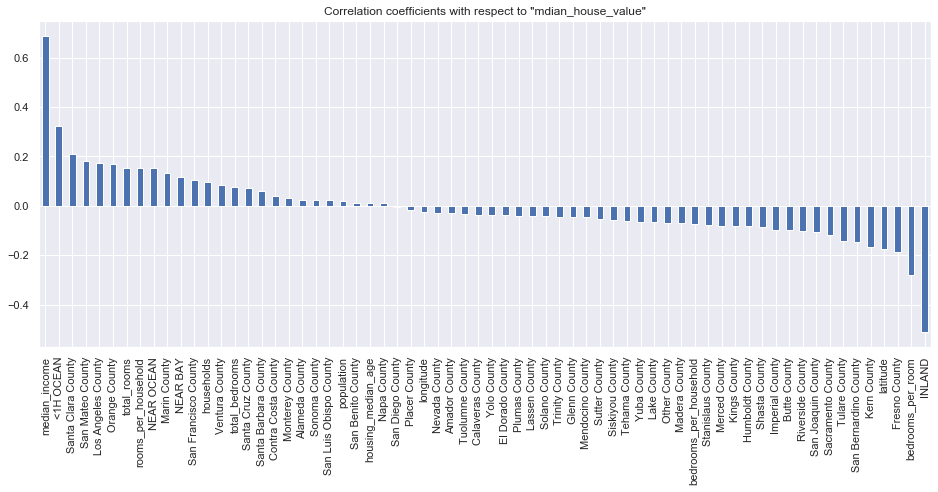

In [88]:
corr_matrix = df_housing_extended3.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)[1:].plot(kind='bar', figsize=(16, 6), 
                                                                        title='Correlation coefficients with respect to \"mdian_house_value\"');

In [89]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(df_housing_extended3[df_housing_extended3.columns.difference(['median_house_value'])],
                                                            df_housing_extended3['median_house_value'])

In [90]:
lin_reg_simple_counties = LinearRegression()
lin_reg_simple_counties.fit(X_train, y_train)
lin_reg_simple_counties_predictions_train = lin_reg_simple_counties.predict(X_train)
lin_reg_simple_counties_predictions_val = lin_reg_simple_counties.predict(X_val)

In [91]:
lin_reg_simple_counties_metrics = calc_error_metrics(lin_reg_simple_counties, X_train,
                                                     y_train, y_val,
                                                     lin_reg_simple_counties_predictions_train,
                                                     lin_reg_simple_counties_predictions_val)

R-Squared Training Set:   0.719
R-Squared Validation Set: 0.726
RMSE Training Set:   50724.1
RMSE Validation Set: 50701.4
MAE Training Set:   36789.4
MAE Validation Set: 36917.8

k-fold CROSS Validation:
Scores:  [51198.17569038 50128.43759828 50943.37522602 51346.3452581 ]
Mean Score:  50904.08344319599
Standard dev.:  470.4402416109795



In [92]:
df_error_metrics.loc['LinReg Model extended counties'] = lin_reg_simple_counties_metrics
df_error_metrics

,R-Squared,RMSE,MAE,CrossVal RMSE,CrossVal Stddev
Mean,-0.00,113260.33,89755.36,nan,nan
Median,-0.05,116033.57,86736.69,nan,nan
LinReg Model 1 feature,0.46,82749.30,62083.10,83734.89,666.57
LinReg Model all features,0.64,67762.72,49568.02,69778.61,262.36
LinReg Model no Lat/Lon,0.56,74292.30,54838.45,76036.64,454.27
LinReg Model no outliers,0.64,67762.72,49568.02,69778.61,262.36
LinReg Model extended features 1,0.68,55234.55,40999.17,55919.59,478.92
LinReg Model extended ocean prox,0.69,54123.45,39928.10,55026.88,533.72
LinReg Model extended counties,0.73,50701.37,36917.82,50904.08,470.44


Another improvement!

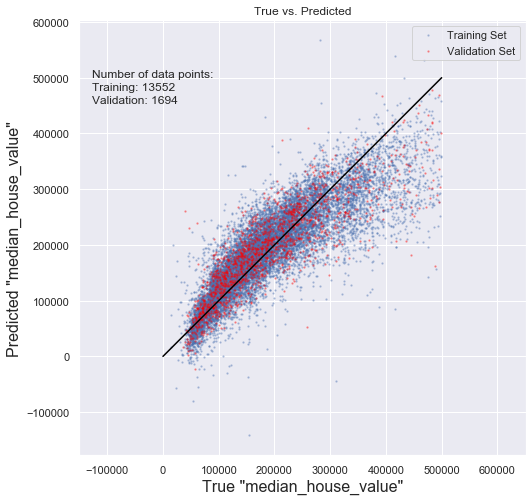

In [93]:
scatter_true_vs_predicted(y_train, lin_reg_simple_counties_predictions_train,
                          y_val, lin_reg_simple_counties_predictions_val)

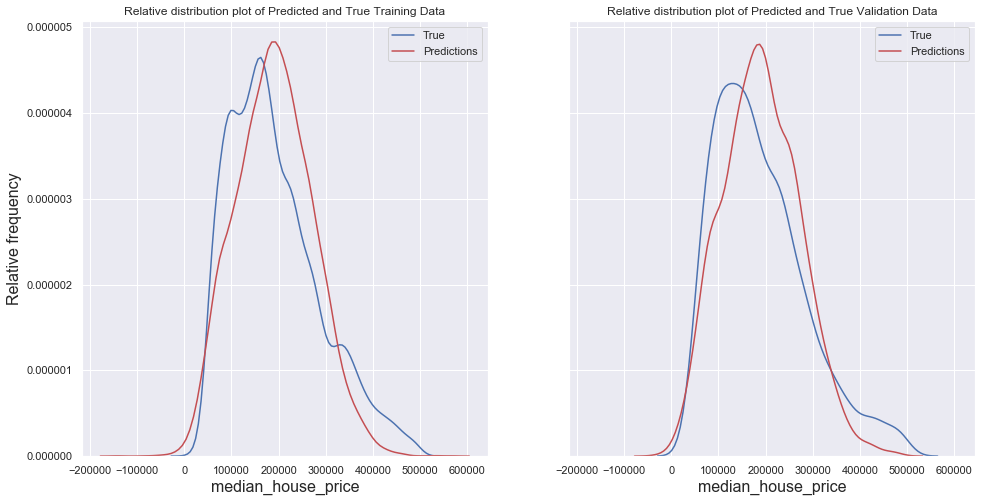

In [94]:
plot_distribution(y_train, lin_reg_simple_counties_predictions_train,
                  y_val, lin_reg_simple_counties_predictions_val)

After having used the columns "Longitude" and "Latitude" to determine which "County" the datapoints belong to, isn't it time to remove the columns "Longitude" and "Latitude"?

In [95]:
df_housing_extended3_1 = df_housing_extended3.drop(['longitude', 'latitude'], axis=1)

In [96]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(df_housing_extended3_1[df_housing_extended3_1.columns.difference(['median_house_value'])],
                                                            df_housing_extended3_1['median_house_value'])

In [97]:
lin_reg_simple_counties_nolonlat = LinearRegression()
lin_reg_simple_counties_nolonlat.fit(X_train, y_train)
lin_reg_simple_counties_nolonlat_predictions_train = lin_reg_simple_counties_nolonlat.predict(X_train)
lin_reg_simple_counties_nolonlat_predictions_val = lin_reg_simple_counties_nolonlat.predict(X_val)

In [98]:
lin_reg_simple_counties_nolonlat_metrics = calc_error_metrics(lin_reg_simple_counties_nolonlat, X_train,
                                                              y_train, y_val,
                                                              lin_reg_simple_counties_nolonlat_predictions_train,
                                                              lin_reg_simple_counties_nolonlat_predictions_val)

R-Squared Training Set:   0.715
R-Squared Validation Set: 0.718
RMSE Training Set:   51112.4
RMSE Validation Set: 51361.1
MAE Training Set:   37046.2
MAE Validation Set: 37451.7

k-fold CROSS Validation:
Scores:  [51624.68987274 50463.03085952 51300.34624213 51742.86058318]
Mean Score:  51282.731889391885
Standard dev.:  500.2183825656064



In [99]:
df_error_metrics.loc['LinReg Model extended counties no Lat/Lon'] = lin_reg_simple_counties_nolonlat_metrics
df_error_metrics

,R-Squared,RMSE,MAE,CrossVal RMSE,CrossVal Stddev
Mean,-0.00,113260.33,89755.36,nan,nan
Median,-0.05,116033.57,86736.69,nan,nan
LinReg Model 1 feature,0.46,82749.30,62083.10,83734.89,666.57
LinReg Model all features,0.64,67762.72,49568.02,69778.61,262.36
LinReg Model no Lat/Lon,0.56,74292.30,54838.45,76036.64,454.27
LinReg Model no outliers,0.64,67762.72,49568.02,69778.61,262.36
LinReg Model extended features 1,0.68,55234.55,40999.17,55919.59,478.92
LinReg Model extended ocean prox,0.69,54123.45,39928.10,55026.88,533.72
LinReg Model extended counties,0.73,50701.37,36917.82,50904.08,470.44
LinReg Model extended counties no Lat/Lon,0.72,51361.05,37451.68,51282.73,500.22


=> As can be seen from error metrics, the Lat/Lon columns should not be discarded from the training data

<br>

# What if I had used Stratified Sampling instead of Random Sampling?
Stratified sampling is important to make sure that both the training and the validation set (and test set) represent a similar distribution of values. I split the column "median_house_value" in several categories:

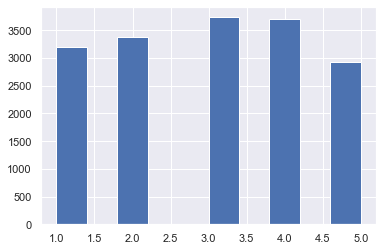

In [100]:
df_housing_stratified = df_housing_extended3.copy(deep=True)
df_housing_stratified['median_house_value_cat'] = pd.cut(df_housing_stratified['median_house_value'],
                                                         bins=[0., 100000, 150000, 200000, 280000, np.inf],
                                                         labels=[1, 2, 3, 4, 5])
df_housing_stratified['median_house_value_cat'].hist();

In [101]:
# 1st split
split = StratifiedShuffleSplit(n_splits=1, test_size=test_size1, random_state=random_st)
for train_index, test_index in split.split(df_housing_stratified, df_housing_stratified['median_house_value_cat']):
    strat_train_set = df_housing_stratified.loc[train_index]
    strat_test_set = df_housing_stratified.loc[test_index]
strat_train_set = strat_train_set.reset_index(drop=True)
strat_test_set = strat_test_set.reset_index(drop=True)

# 2nd split
split = StratifiedShuffleSplit(n_splits=1, test_size=test_size2, random_state=random_st)
for val_index, test_index in split.split(strat_test_set, strat_test_set['median_house_value_cat']):
    strat_val_set = strat_test_set.loc[val_index]
    strat_test_set = strat_test_set.loc[test_index]
strat_val_set = strat_val_set.reset_index(drop=True)
strat_test_set = strat_test_set.reset_index(drop=True)

In [102]:
distribution_overall = df_housing_stratified['median_house_value_cat'].value_counts()/len(df_housing_stratified) * 100
distribution_train_set = strat_train_set['median_house_value_cat'].value_counts()/len(strat_train_set) * 100
distribution_val_set = strat_val_set['median_house_value_cat'].value_counts()/len(strat_val_set) * 100
distribution_test_set = strat_test_set['median_house_value_cat'].value_counts()/len(strat_test_set) * 100

In [103]:
pd.DataFrame({'Overall %': distribution_overall,
              'Training Set %': distribution_train_set,
              'Validation Set %': distribution_val_set,
              'Test Set %': distribution_test_set,
              'Training Set % Deviation': ((distribution_train_set - distribution_overall) / distribution_overall * 100),
              'Validation Set % Deviation': ((distribution_val_set - distribution_overall) / distribution_overall * 100),
              'Test Set % Deviation': ((distribution_test_set - distribution_overall) / distribution_overall * 100),
             }).sort_index()

,Overall %,Training Set %,Validation Set %,Test Set %,Training Set % Deviation,Validation Set % Deviation,Test Set % Deviation
1,18.85,18.85,18.83,18.89,-0.02,-0.09,0.22
2,19.91,19.91,19.89,19.95,-0.01,-0.09,0.21
3,22.06,22.06,22.08,22.02,0.01,0.08,-0.19
4,21.90,21.90,21.90,21.90,0.00,0.00,0.00
5,17.28,17.28,17.30,17.24,0.02,0.10,-0.24


In [104]:
# Remove the "income_cat" feature so that data is back in its original state
for set_ in (strat_train_set, strat_val_set, strat_test_set):
    set_.drop('median_house_value_cat', axis=1, inplace=True)

In [105]:
X_train, y_train = strat_train_set.drop('median_house_value', axis=1), strat_train_set['median_house_value'].copy()
X_val, y_val = strat_test_set.drop('median_house_value', axis=1), strat_test_set['median_house_value'].copy()

In [106]:
lin_reg_simple_stratified = LinearRegression()
lin_reg_simple_stratified.fit(X_train, y_train)
lin_reg_simple_stratified_predictions_train = lin_reg_simple_stratified.predict(X_train)
lin_reg_simple_stratified_predictions_val = lin_reg_simple_stratified.predict(X_val)

In [107]:
lin_reg_simple_stratified_metrics = calc_error_metrics(lin_reg_simple_stratified, X_train,
                                                       y_train, y_val,
                                                       lin_reg_simple_stratified_predictions_train,
                                                       lin_reg_simple_stratified_predictions_val)

R-Squared Training Set:   0.723
R-Squared Validation Set: 0.719
RMSE Training Set:   50732.5
RMSE Validation Set: 50512.0
MAE Training Set:   36829.3
MAE Validation Set: 36769.5

k-fold CROSS Validation:
Scores:  [50955.35289237 50920.98932062 50808.84954893 51226.7306465 ]
Mean Score:  50977.980602105905
Standard dev.:  153.49423209495794



In [108]:
df_error_metrics.loc['LinReg Model stratified'] = lin_reg_simple_stratified_metrics
df_error_metrics

,R-Squared,RMSE,MAE,CrossVal RMSE,CrossVal Stddev
Mean,-0.00,113260.33,89755.36,nan,nan
Median,-0.05,116033.57,86736.69,nan,nan
LinReg Model 1 feature,0.46,82749.30,62083.10,83734.89,666.57
LinReg Model all features,0.64,67762.72,49568.02,69778.61,262.36
LinReg Model no Lat/Lon,0.56,74292.30,54838.45,76036.64,454.27
LinReg Model no outliers,0.64,67762.72,49568.02,69778.61,262.36
LinReg Model extended features 1,0.68,55234.55,40999.17,55919.59,478.92
LinReg Model extended ocean prox,0.69,54123.45,39928.10,55026.88,533.72
LinReg Model extended counties,0.73,50701.37,36917.82,50904.08,470.44
LinReg Model extended counties no Lat/Lon,0.72,51361.05,37451.68,51282.73,500.22


The predictions of the model with the stratified training data resulted in no improvement (compared to LinReg Model extended counties). Though it is remarkable how the standard deviation was reduced!<br>
(split into 4 => no improvement; split into 10 => no improvement).

<br>

# Feature Scaling
Machine learning algorithms don't perform well when the features have very different scales (see page 69). <br>
This does not apply to Linear Regression, because of the algorithm (SVD) used in this case. The following lines of code will prove that.
(The categorical values of the feature "ocean_proximity" won't be scaled.)

In [109]:
df_housing_scaled = df_housing_extended3.copy(deep=True)

In [110]:
standard_scaler = StandardScaler()
df_housing_scaled.iloc[:, 0:8] = standard_scaler.fit_transform(df_housing_scaled.iloc[:, 0:8])
df_housing_scaled.iloc[:, 9:12] = standard_scaler.fit_transform(df_housing_scaled.iloc[:, 9:12])

In [111]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(df_housing_scaled[df_housing_scaled.columns.difference(['median_house_value'])],
                                                            df_housing_scaled['median_house_value'])

In [112]:
lin_reg_simple_scaled = LinearRegression()
lin_reg_simple_scaled.fit(X_train, y_train)
lin_reg_simple_scaled_predictions_train = lin_reg_simple_scaled.predict(X_train)
lin_reg_simple_scaled_predictions_val = lin_reg_simple_scaled.predict(X_val)

In [113]:
lin_reg_simple_scaled_metrics = calc_error_metrics(lin_reg_simple_scaled, X_train,
                                                   y_train, y_val,
                                                   lin_reg_simple_scaled_predictions_train,
                                                   lin_reg_simple_scaled_predictions_val)

R-Squared Training Set:   0.719
R-Squared Validation Set: 0.726
RMSE Training Set:   50728.5
RMSE Validation Set: 50694.0
MAE Training Set:   36800.7
MAE Validation Set: 36918.5

k-fold CROSS Validation:
Scores:  [51209.47110715 50101.57897938 50956.82640423 51355.28208671]
Mean Score:  50905.78964436674
Standard dev.:  485.70192276213925



In [114]:
df_error_metrics.loc['LinReg Model extended standardized'] = lin_reg_simple_scaled_metrics
df_error_metrics

,R-Squared,RMSE,MAE,CrossVal RMSE,CrossVal Stddev
Mean,-0.00,113260.33,89755.36,nan,nan
Median,-0.05,116033.57,86736.69,nan,nan
LinReg Model 1 feature,0.46,82749.30,62083.10,83734.89,666.57
LinReg Model all features,0.64,67762.72,49568.02,69778.61,262.36
LinReg Model no Lat/Lon,0.56,74292.30,54838.45,76036.64,454.27
LinReg Model no outliers,0.64,67762.72,49568.02,69778.61,262.36
LinReg Model extended features 1,0.68,55234.55,40999.17,55919.59,478.92
LinReg Model extended ocean prox,0.69,54123.45,39928.10,55026.88,533.72
LinReg Model extended counties,0.73,50701.37,36917.82,50904.08,470.44
LinReg Model extended counties no Lat/Lon,0.72,51361.05,37451.68,51282.73,500.22


The model with the standardized data (based on the "LinReg Model extended counties") did not result in better error metrics.

<br>

The Linear Regression algorithm of scikit-learn has the option to normalize the data internally. Let's see what that would resulted in.

In [115]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(df_housing_extended3[df_housing_extended3.columns.difference(['median_house_value'])],
                                                            df_housing_extended3['median_house_value'])

In [116]:
lin_reg_simple_scaled_intern = LinearRegression(normalize=True)
lin_reg_simple_scaled_intern.fit(X_train, y_train)
lin_reg_simple_scaled_intern_predictions_train = lin_reg_simple_scaled_intern.predict(X_train)
lin_reg_simple_scaled_intern_predictions_val = lin_reg_simple_scaled_intern.predict(X_val)

In [117]:
lin_reg_simple_scaled_intern_metrics = calc_error_metrics(lin_reg_simple_scaled_intern, X_train,
                                                   y_train, y_val,
                                                   lin_reg_simple_scaled_intern_predictions_train,
                                                   lin_reg_simple_scaled_intern_predictions_val)

R-Squared Training Set:   0.719
R-Squared Validation Set: 0.726
RMSE Training Set:   50725.4
RMSE Validation Set: 50705.2
MAE Training Set:   36792.9
MAE Validation Set: 36916.3

k-fold CROSS Validation:
Scores:  [51194.53511332 50149.79266649 50936.08499513 51348.99634734]
Mean Score:  50907.35228056838
Standard dev.:  461.5857447214346



The results are very similar to the results above.

<br>

# Using a degree 2 polynomial Linear Regression Model

In [118]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(df_housing_extended3[df_housing_extended3.columns.difference(['median_house_value'])],
                                                            df_housing_extended3['median_house_value'])

In [119]:
%%time
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
X_val_poly = poly.fit_transform(X_val)

lin_reg_poly = LinearRegression(n_jobs=-1)
lin_reg_poly.fit(X_train_poly, y_train)
print(X_train_poly.shape)

(13552, 2278)
CPU times: user 17 s, sys: 740 ms, total: 17.8 s
Wall time: 10.3 s


In [120]:
lin_reg_poly_predictions_train = lin_reg_poly.predict(X_train_poly)
lin_reg_poly_predictions_val = lin_reg_poly.predict(X_val_poly)

In [121]:
%%time
lin_reg_poly_metrics = calc_error_metrics(lin_reg_poly, X_train_poly,
                                          y_train, y_val,
                                          lin_reg_poly_predictions_train,
                                          lin_reg_poly_predictions_val)

R-Squared Training Set:   0.813
R-Squared Validation Set: 0.777
RMSE Training Set:   41357.5
RMSE Validation Set: 45665.8
MAE Training Set:   28930.9
MAE Validation Set: 31217.2

k-fold CROSS Validation:
Scores:  [84669.69588791 46983.65234702 48996.42664405 54438.62133835]
Mean Score:  58772.09905433384
Standard dev.:  15198.649592265003

CPU times: user 212 ms, sys: 171 ms, total: 383 ms
Wall time: 39.1 s


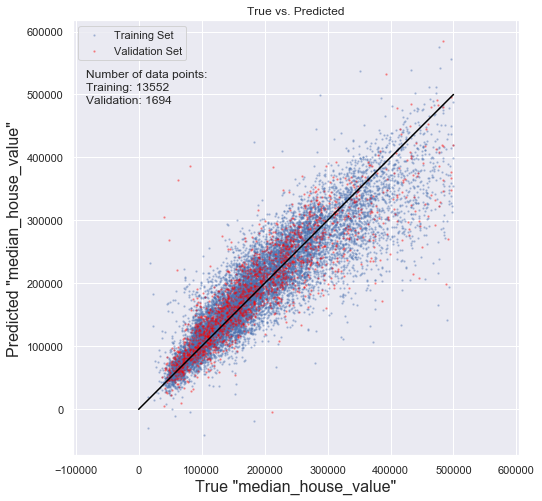

In [122]:
scatter_true_vs_predicted(y_train, lin_reg_poly_predictions_train,
                          y_val, lin_reg_poly_predictions_val)

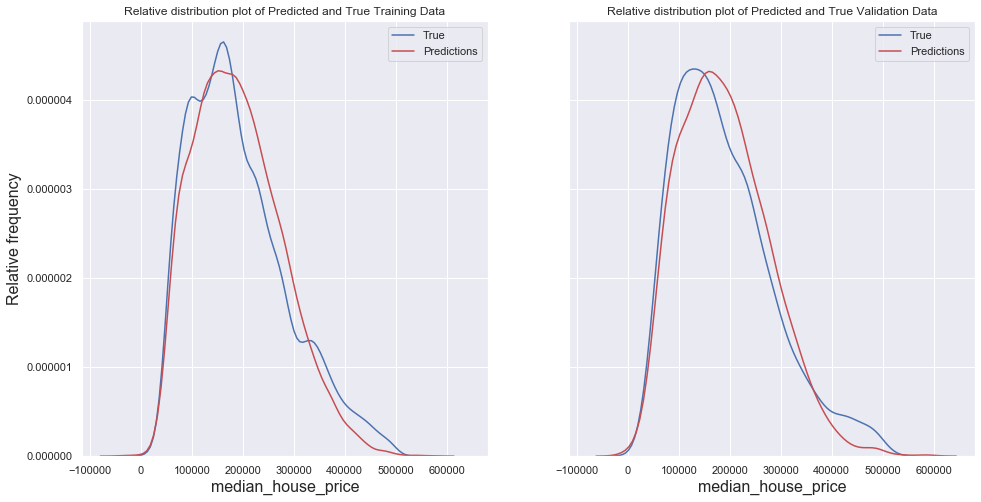

In [123]:
plot_distribution(y_train, lin_reg_poly_predictions_train,
                  y_val, lin_reg_poly_predictions_val)

In [124]:
df_error_metrics.loc['LinReg 2nd degree polynom'] = lin_reg_poly_metrics
df_error_metrics

,R-Squared,RMSE,MAE,CrossVal RMSE,CrossVal Stddev
Mean,-0.00,113260.33,89755.36,nan,nan
Median,-0.05,116033.57,86736.69,nan,nan
LinReg Model 1 feature,0.46,82749.30,62083.10,83734.89,666.57
LinReg Model all features,0.64,67762.72,49568.02,69778.61,262.36
LinReg Model no Lat/Lon,0.56,74292.30,54838.45,76036.64,454.27
LinReg Model no outliers,0.64,67762.72,49568.02,69778.61,262.36
LinReg Model extended features 1,0.68,55234.55,40999.17,55919.59,478.92
LinReg Model extended ocean prox,0.69,54123.45,39928.10,55026.88,533.72
LinReg Model extended counties,0.73,50701.37,36917.82,50904.08,470.44
LinReg Model extended counties no Lat/Lon,0.72,51361.05,37451.68,51282.73,500.22


The metrics of the training and validation data show improved numbers, but the metrics of the RMSE-validation data have worsened. What has happened here? => In case anybody can explain this, please send me an e-mail (dirkschulz_3@yahoo.de) <br>
Several negative predicted values in the scatter plot.

<br>

# Ridge-Regression (L2-Regression)

In [125]:
%%time

#param_grid = {'alpha': [0.0001, 0.00012, 0.00014, 0.00016, 0.00018, 0.0002, 0.00022, 0.00024, 0.00026, 0.00028, 0.0003]}
param_grid = {'alpha': [0.00018]}
lin_reg_poly_l2 = Ridge()
lin_reg_poly_l2_grid_search = GridSearchCV(lin_reg_poly_l2, param_grid, cv=4,
                                           scoring='neg_mean_squared_error', return_train_score=True, n_jobs=-1)
lin_reg_poly_l2_grid_search.fit(X_train_poly, y_train)

CPU times: user 2.85 s, sys: 488 ms, total: 3.34 s
Wall time: 10.2 s


/Users/dirkschulz/anaconda3/envs/portfolio/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.49398e-24): result may not be accurate.
  overwrite_a=True).T


GridSearchCV(cv=4, error_score=nan,
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='deprecated', n_jobs=-1, param_grid={'alpha': [0.00018]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='neg_mean_squared_error', verbose=0)

In [126]:
results = lin_reg_poly_l2_grid_search.cv_results_
for mean_score, params in zip(results['mean_test_score'], results['params']):
    print(np.sqrt(-mean_score), params)

45993.94355796956 {'alpha': 0.00018}


In [127]:
lin_reg_poly_l2 = Ridge(alpha=0.00018)
lin_reg_poly_l2.fit(X_train_poly, y_train)

/Users/dirkschulz/anaconda3/envs/portfolio/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.49398e-24): result may not be accurate.
  overwrite_a=True).T


Ridge(alpha=0.00018, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [128]:
lin_reg_poly_l2_predictions_train = lin_reg_poly_l2.predict(X_train_poly)
lin_reg_poly_l2_predictions_val = lin_reg_poly_l2.predict(X_val_poly)

In [129]:
%%time
lin_reg_poly_l2_metrics = calc_error_metrics(lin_reg_poly_l2, X_train_poly,
                                             y_train, y_val,
                                             lin_reg_poly_l2_predictions_train,
                                             lin_reg_poly_l2_predictions_val)

R-Squared Training Set:   0.812
R-Squared Validation Set: 0.780
RMSE Training Set:   41500.3
RMSE Validation Set: 45436.1
MAE Training Set:   29060.1
MAE Validation Set: 31184.0

k-fold CROSS Validation:
Scores:  [46532.46833502 46129.19100414 46110.99974911 45192.63442362]
Mean Score:  45991.3233779706
Standard dev.:  490.93579684546114

CPU times: user 252 ms, sys: 147 ms, total: 399 ms
Wall time: 5.54 s


In [130]:
df_error_metrics.loc['LinReg 2nd degree polynom L2'] = lin_reg_poly_l2_metrics
df_error_metrics

,R-Squared,RMSE,MAE,CrossVal RMSE,CrossVal Stddev
Mean,-0.00,113260.33,89755.36,nan,nan
Median,-0.05,116033.57,86736.69,nan,nan
LinReg Model 1 feature,0.46,82749.30,62083.10,83734.89,666.57
LinReg Model all features,0.64,67762.72,49568.02,69778.61,262.36
LinReg Model no Lat/Lon,0.56,74292.30,54838.45,76036.64,454.27
LinReg Model no outliers,0.64,67762.72,49568.02,69778.61,262.36
LinReg Model extended features 1,0.68,55234.55,40999.17,55919.59,478.92
LinReg Model extended ocean prox,0.69,54123.45,39928.10,55026.88,533.72
LinReg Model extended counties,0.73,50701.37,36917.82,50904.08,470.44
LinReg Model extended counties no Lat/Lon,0.72,51361.05,37451.68,51282.73,500.22


The error metrics compared to "LinReg 2nd degree polynom" have improved, especially the CrossVal RMSE did improve and is the best so far. **"CrossVal RMSE: 45991.32".** <br>
Determining the best model by only looking at "CrossVal RMSE" is actually a waste of the 10% validation data. The validation data was used to compute R-squared RMSE and MAE, whereas the "CrossVal RMSE" was computed from the training data only. So an improvement of the process above is to add the 10 % validation data to either the training or test data. To get an idea of how much additional training data would help to improve the model an option is to look at the learning curve:

In [131]:
def plot_learning_curves(model):
    X_train, X_val, y_train, y_val = train_test_split(df_housing_extended3[df_housing_extended3.columns.difference(['median_house_value'])],
                                                      df_housing_extended3['median_house_value'],
                                                      test_size=test_size1, random_state=random_st)
    errors_train, errors_val = [], []
    #training_sizes = list(range(100,13600,100))
    training_sizes = list(range(500,14000,500))
    for m in training_sizes:
        model.fit(X_train[:m], y_train[:m])
        predictions_train = model.predict(X_train[:m])
        predictions_val = model.predict(X_val)
        errors_train.append(mean_squared_error(y_train[:m], predictions_train))
        errors_val.append(mean_squared_error(y_val, predictions_val))
    plt.plot(training_sizes, np.sqrt(errors_train), 'r-', lw=2, label='train')
    plt.plot(training_sizes, np.sqrt(errors_val), 'b-', lw=2, label='val')
    #plt.gca().set_ylim(42000, 58000)
    plt.gca().set_ylim(0, 60000)
    plt.gca().set_title('Learning Curves')
    plt.gca().set_xlabel('Training Size')
    plt.gca().set_ylabel('RMSE')
    plt.gca().legend()

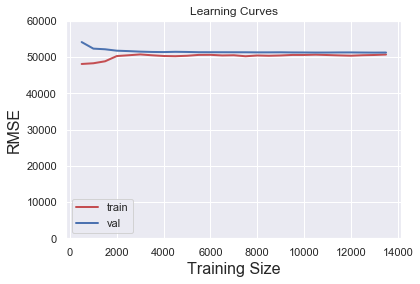

In [132]:
lin_reg_curve = LinearRegression()
plot_learning_curves(lin_reg_poly_l2)

A different value for the parameter "random_state" would lead to significantly different figures (e.g. random_state=random_st2). Another reason why determining a model based on its cross-validation score should be preferred.

<br>

# Training a Random Forest Regressor Model

I use the data from after I removed the outliers in the "median_house_price" column (see several steps further up)

In [133]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(df_housing_extended3[df_housing_extended3.columns.difference(['median_house_value'])],
                                                            df_housing_extended3['median_house_value'])

In [134]:
X_train.shape

(13552, 66)

In [135]:
X_train.memory_usage(deep=True).sum() / 1024 / 1024

1.9515533447265625

Grid search:

In [136]:
%%time
from sklearn.ensemble import RandomForestRegressor

forest_regr = RandomForestRegressor(n_jobs=-1)

param_grid = [
    #{'n_estimators': [100, 200, 400],
    # 'max_features': [20, 30, 40, 50]},
    #{'bootstrap': [False], 
    # 'n_estimators': [100, 200, 400],
    # 'max_features': [20, 30, 40, 50]}
    {'bootstrap': [False],
     'n_estimators': [400],
     'max_features': [30]}
]

grid_search = GridSearchCV(forest_regr, 
                           param_grid, cv=4, 
                           scoring='neg_mean_squared_error',
                           n_jobs=-1,
                           return_train_score=True)
grid_search.fit(X_train, y_train)

CPU times: user 1min 4s, sys: 926 ms, total: 1min 5s
Wall time: 1min 16s


GridSearchCV(cv=4, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=-1,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jobs

In [137]:
cv_results = grid_search.cv_results_
for mean_score, params in zip(cv_results['mean_test_score'], cv_results['params']):
    print(np.sqrt(-mean_score), params)

40632.539550622496 {'bootstrap': False, 'max_features': 30, 'n_estimators': 400}


In [138]:
forest_regr = RandomForestRegressor(n_jobs=-1, bootstrap=False, max_features=30, n_estimators=400)
forest_regr.fit(X_train, y_train)

RandomForestRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=30, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=400, n_jobs=-1, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

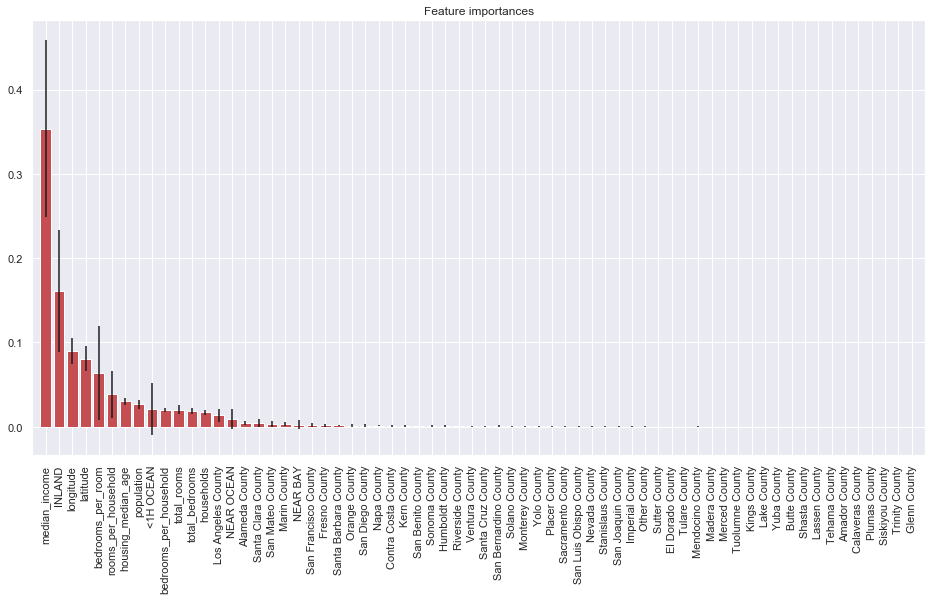

In [139]:
# Plot the feature importances of the forest
importances = forest_regr.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest_regr.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(16, 8))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()

In [140]:
forest_regr_predictions_train = forest_regr.predict(X_train)
forest_regr_predictions_val = forest_regr.predict(X_val)

In [141]:
%%time
forest_regr_metrics = calc_error_metrics(forest_regr, X_train,
                                         y_train, y_val,
                                         forest_regr_predictions_train,
                                         forest_regr_predictions_val)

R-Squared Training Set:   1.000
R-Squared Validation Set: 0.825
RMSE Training Set:   0.0
RMSE Validation Set: 40454.7
MAE Training Set:   0.0
MAE Validation Set: 27151.1

k-fold CROSS Validation:
Scores:  [39711.15759294 40632.63965559 41423.71396169 40967.48172388]
Mean Score:  40683.74823352747
Standard dev.:  627.8133905258514

CPU times: user 38.5 ms, sys: 33.5 ms, total: 71.9 ms
Wall time: 1min 1s


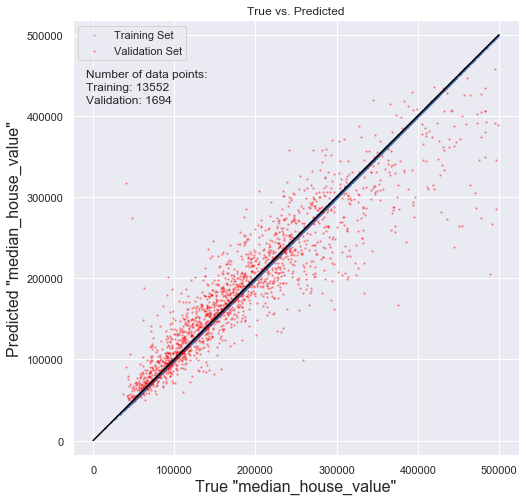

In [142]:
scatter_true_vs_predicted(y_train, forest_regr_predictions_train,
                          y_val, forest_regr_predictions_val)

In contrast to the Linear Regression models no negative values were predicted.

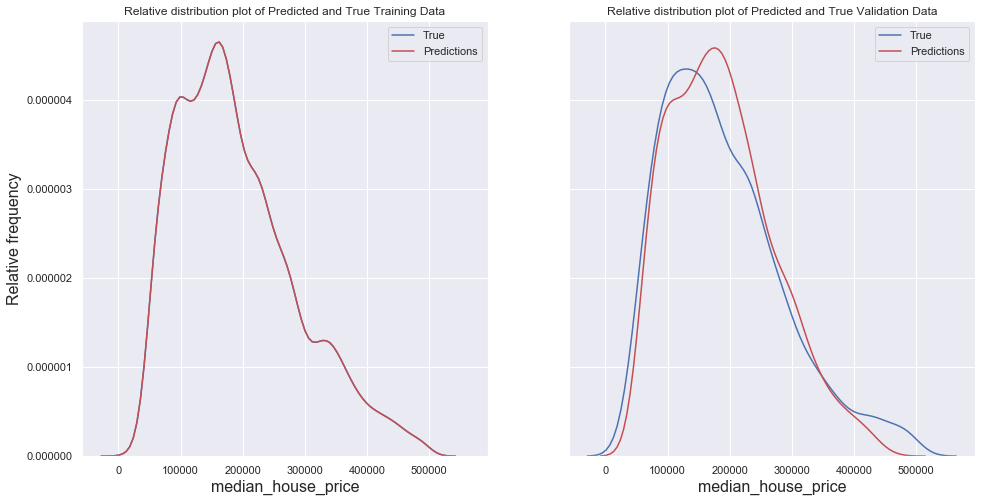

In [143]:
plot_distribution(y_train, forest_regr_predictions_train,
                  y_val, forest_regr_predictions_val)

In [144]:
df_error_metrics.loc['Random Forest'] = forest_regr_metrics
df_error_metrics

,R-Squared,RMSE,MAE,CrossVal RMSE,CrossVal Stddev
Mean,-0.00,113260.33,89755.36,nan,nan
Median,-0.05,116033.57,86736.69,nan,nan
LinReg Model 1 feature,0.46,82749.30,62083.10,83734.89,666.57
LinReg Model all features,0.64,67762.72,49568.02,69778.61,262.36
LinReg Model no Lat/Lon,0.56,74292.30,54838.45,76036.64,454.27
LinReg Model no outliers,0.64,67762.72,49568.02,69778.61,262.36
LinReg Model extended features 1,0.68,55234.55,40999.17,55919.59,478.92
LinReg Model extended ocean prox,0.69,54123.45,39928.10,55026.88,533.72
LinReg Model extended counties,0.73,50701.37,36917.82,50904.08,470.44
LinReg Model extended counties no Lat/Lon,0.72,51361.05,37451.68,51282.73,500.22


The error metrics of the Random Forest Regressor have strongly improved. However, the model is strongly overfitted (The model fitted with the Training data does not show any error! It's completely memorized). In the next step, I try regularization by changing the hyperparameter "max_depth" and "min_samples_leaf". <br>

### Regularization

In [145]:
%%time
forest_regr_reg = RandomForestRegressor(n_jobs=-1)

param_grid = [
     {'bootstrap': [False],
      'n_estimators': [400],
      'max_features': [30],
     #{'max_depth': [20, 30, 40, 50, 60, 80, 100]}
      'max_depth': [60]}
]

grid_search = GridSearchCV(forest_regr_reg, 
                           param_grid, cv=4, 
                           scoring='neg_mean_squared_error',
                           n_jobs=-1,
                           return_train_score=True)
grid_search.fit(X_train, y_train)

CPU times: user 1min 3s, sys: 892 ms, total: 1min 3s
Wall time: 1min 24s


GridSearchCV(cv=4, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=-1,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jobs

In [146]:
cv_results = grid_search.cv_results_
for mean_score, params in zip(cv_results['mean_test_score'], cv_results['params']):
    print(np.sqrt(-mean_score), params)

40642.77266305807 {'bootstrap': False, 'max_depth': 60, 'max_features': 30, 'n_estimators': 400}


In [147]:
%%time
forest_regr_reg = RandomForestRegressor(n_jobs=-1)

param_grid = [
    {'bootstrap': [False], 
     'n_estimators': [400],
     'max_features': [30],
     'max_depth': [60],
     #'min_samples_leaf':[1, 2, 3, 4, 5]}
     'min_samples_leaf':[1]}
]

grid_search = GridSearchCV(forest_regr_reg, 
                           param_grid, cv=4, 
                           scoring='neg_mean_squared_error',
                           n_jobs=-1,
                           return_train_score=True)
grid_search.fit(X_train, y_train)

CPU times: user 1min 3s, sys: 987 ms, total: 1min 4s
Wall time: 1min 28s


GridSearchCV(cv=4, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=-1,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jobs

In [148]:
cv_results = grid_search.cv_results_
for mean_score, params in zip(cv_results['mean_test_score'], cv_results['params']):
    print(np.sqrt(-mean_score), params)

40630.469442419315 {'bootstrap': False, 'max_depth': 60, 'max_features': 30, 'min_samples_leaf': 1, 'n_estimators': 400}


In [149]:
forest_regr_reg_depth_samples = RandomForestRegressor(n_jobs=-1, bootstrap=False, max_features=30, n_estimators=400,
                                                      max_depth=60, min_samples_leaf=1)
forest_regr_reg_depth_samples.fit(X_train, y_train)

RandomForestRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                      max_depth=60, max_features=30, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=400, n_jobs=-1, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [150]:
forest_regr_reg_depth_samples_predictions_train = forest_regr_reg_depth_samples.predict(X_train)
forest_regr_reg_depth_samples_predictions_val = forest_regr_reg_depth_samples.predict(X_val)

In [151]:
%%time
forest_regr_reg_depth_samples_metrics = calc_error_metrics(forest_regr_reg_depth_samples, X_train,
                                                           y_train, y_val,
                                                           forest_regr_reg_depth_samples_predictions_train,
                                                           forest_regr_reg_depth_samples_predictions_val)

R-Squared Training Set:   1.000
R-Squared Validation Set: 0.825
RMSE Training Set:   0.2
RMSE Validation Set: 40481.6
MAE Training Set:   0.0
MAE Validation Set: 27240.4

k-fold CROSS Validation:
Scores:  [39989.02957192 40542.17743106 41324.47163858 40880.22028302]
Mean Score:  40683.974731145165
Standard dev.:  487.8021765299148

CPU times: user 34.6 ms, sys: 16.5 ms, total: 51.1 ms
Wall time: 1min 3s


In [152]:
df_error_metrics.loc['Random Forest, regularized'] = forest_regr_reg_depth_samples_metrics
df_error_metrics

,R-Squared,RMSE,MAE,CrossVal RMSE,CrossVal Stddev
Mean,-0.00,113260.33,89755.36,nan,nan
Median,-0.05,116033.57,86736.69,nan,nan
LinReg Model 1 feature,0.46,82749.30,62083.10,83734.89,666.57
LinReg Model all features,0.64,67762.72,49568.02,69778.61,262.36
LinReg Model no Lat/Lon,0.56,74292.30,54838.45,76036.64,454.27
LinReg Model no outliers,0.64,67762.72,49568.02,69778.61,262.36
LinReg Model extended features 1,0.68,55234.55,40999.17,55919.59,478.92
LinReg Model extended ocean prox,0.69,54123.45,39928.10,55026.88,533.72
LinReg Model extended counties,0.73,50701.37,36917.82,50904.08,470.44
LinReg Model extended counties no Lat/Lon,0.72,51361.05,37451.68,51282.73,500.22


The regularization did not lead to an improvement of the error metrics.

<br>

As with the Linear Regression Model, I also would like to know, if additional training data could improve the Random Forest Regression Model

CPU times: user 14min 33s, sys: 13.3 s, total: 14min 46s
Wall time: 11min 17s


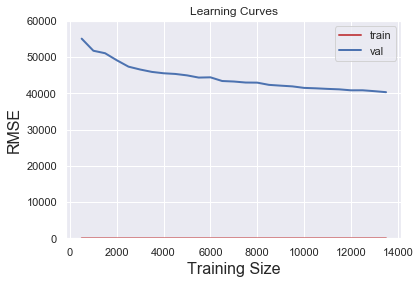

In [153]:
%%time
plot_learning_curves(forest_regr)  # change axis limits in the function "plot_learning_curves" further up

The RMSE of the Validation Set steadily decreases. In my opinion it's safe to assume that, based on this figure, with additional Training Data the RMSE (and the Cross-Val RMSE ) would decrease further.

<br>

# Final Step: Error metrics of the "TEST SET"

In [154]:
forest_regr_predictions_test = forest_regr.predict(X_test)
forest_regr_test_metrics = calc_error_metrics(forest_regr, X_train,
                                              y_train, y_test,
                                              forest_regr_predictions_train,
                                              forest_regr_predictions_test)

R-Squared Training Set:   1.000
R-Squared Validation Set: 0.831
RMSE Training Set:   0.0
RMSE Validation Set: 40303.6
MAE Training Set:   0.0
MAE Validation Set: 26990.3

k-fold CROSS Validation:
Scores:  [39812.20303679 40535.68658758 41264.40917465 40898.42164933]
Mean Score:  40627.68011208549
Standard dev.:  536.7006959175299



In [155]:
df_error_metrics.loc['Random Forest, TEST SET'] = forest_regr_test_metrics
df_error_metrics

,R-Squared,RMSE,MAE,CrossVal RMSE,CrossVal Stddev
Mean,-0.00,113260.33,89755.36,nan,nan
Median,-0.05,116033.57,86736.69,nan,nan
LinReg Model 1 feature,0.46,82749.30,62083.10,83734.89,666.57
LinReg Model all features,0.64,67762.72,49568.02,69778.61,262.36
LinReg Model no Lat/Lon,0.56,74292.30,54838.45,76036.64,454.27
LinReg Model no outliers,0.64,67762.72,49568.02,69778.61,262.36
LinReg Model extended features 1,0.68,55234.55,40999.17,55919.59,478.92
LinReg Model extended ocean prox,0.69,54123.45,39928.10,55026.88,533.72
LinReg Model extended counties,0.73,50701.37,36917.82,50904.08,470.44
LinReg Model extended counties no Lat/Lon,0.72,51361.05,37451.68,51282.73,500.22


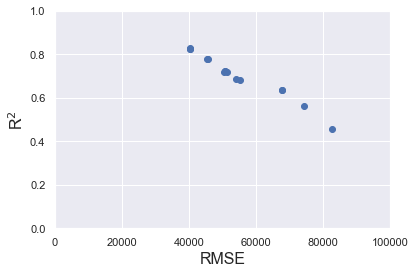

In [164]:
plt.scatter(df_error_metrics.iloc[2:, 1], df_error_metrics.iloc[2:, 0])
plt.xlabel('RMSE')
plt.ylabel('R$^2$')
plt.xlim(0, 100000)
plt.ylim(0, 1);